# Applying Machine Learning Models

In [49]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [50]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [51]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

print(features_act)
print(features_uid)

['angle4()', 't_grav_acc_min()_X', 't_grav_acc_mean()_X', 't_grav_acc_max()_X', 't_grav_acc_min()_Y', 't_grav_acc_energy()_X', 'angle5()', 't_grav_acc_max()_Y', 't_grav_acc_mean()_Y', 't_grav_acc_Mag_energy()', 't_grav_acc_energy()_Y', 't_grav_acc_Mag_min()', 't_grav_acc_Mag_mean()', 't_grav_acc_entropy()_X', 't_body_acc_max()_X', 'angle6()', 'f_body_acc_std()_X', 't_body_acc_Mag_std()', 'f_body_gyro_maxInd()_Z', 'f_body_acc_Jerk_BE[1-8]_X', 'f_body_acc_Mag_kurtosis()', 'f_body_acc_BE[1-8]_Z', 'f_body_acc_BE[1-8]_X', 'f_body_acc_energy()_X', 't_grav_acc_Mag_sma()', 'f_body_acc_Mag_skewness()', 't_body_gyro_Jerk_energy()_X', 't_grav_acc_mean()_Z', 't_grav_acc_min()_Z', 'f_body_acc_BE[1-8]_Y', 'f_body_acc_BE[1-24]_X', 't_body_acc_std()_X', 't_body_acc_Mag_max()', 'f_body_acc_Mag_mean()', 't_body_acc_energy()_X', 't_body_acc_jerk_Mag_iqr()', 't_body_acc_Mag_AR1()', 'f_body_acc_Mag_sma()', 't_grav_acc_max()_Z', 't_body_acc_Corr(X,Y)', 't_body_acc_Mag_entropy()', 'f_body_acc_Jerk_BE[1-8]_Y'

In [52]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [53]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [54]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [55]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [56]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [57]:
weighted_epsilon_array = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0]
weighted_epsilon = weighted_epsilon_array[2]

## 2. Random Forest Classifier

## UID

--------
n:  500
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:48.649042

Predicting test data
==> testing time:- 0:00:00.242571

==> Accuracy:- 0.22415490646537578


 ********Confusion Matrix********

 [[43  0  2  0  2  0  2  2  0  2  0  0  1  1  2  3 10  2  3  0  3  0  5 12
   3  4  0  0 15  3]
 [ 2  3  2  2  2  4  2  1  0  5  1  2  1  2  2  1  4  2  6  0 13  7  2 10
   1  4  8  0 12  2]
 [ 0  1 19  2  1  2  0  1  0  6  7  2  0  0  2  2  5  4  4  1  4  2  4  8
   4  3  0  2  6  3]
 [ 0  1  5 14  3  4  0  0  1  1  4  1  1  0  2  0  1 16  2  1  4  6  3  1
   5  5  1  2  6  2]
 [ 4  1  1  3 20  6  3  2  0  3  2  0  3  0  1  1  3  0  1  0  4  0  5 11
   2  7  1  1  3  1]
 [10  0  2  0  2 16  2  2  0  1  1  1  2  1  1  0  2  1  2  1  4  2 14  7
   1  6  2  4  1  0]
 [ 7  0  0  1  2  4 14  1  1  1  0  0  1  0  0  1  1  4  2  0  8  0  7  8
   7  2  4  1  5  1]
 [ 6  0  0  1  1  1  0 15  0  4  0  0  1  0  1  0  5  0

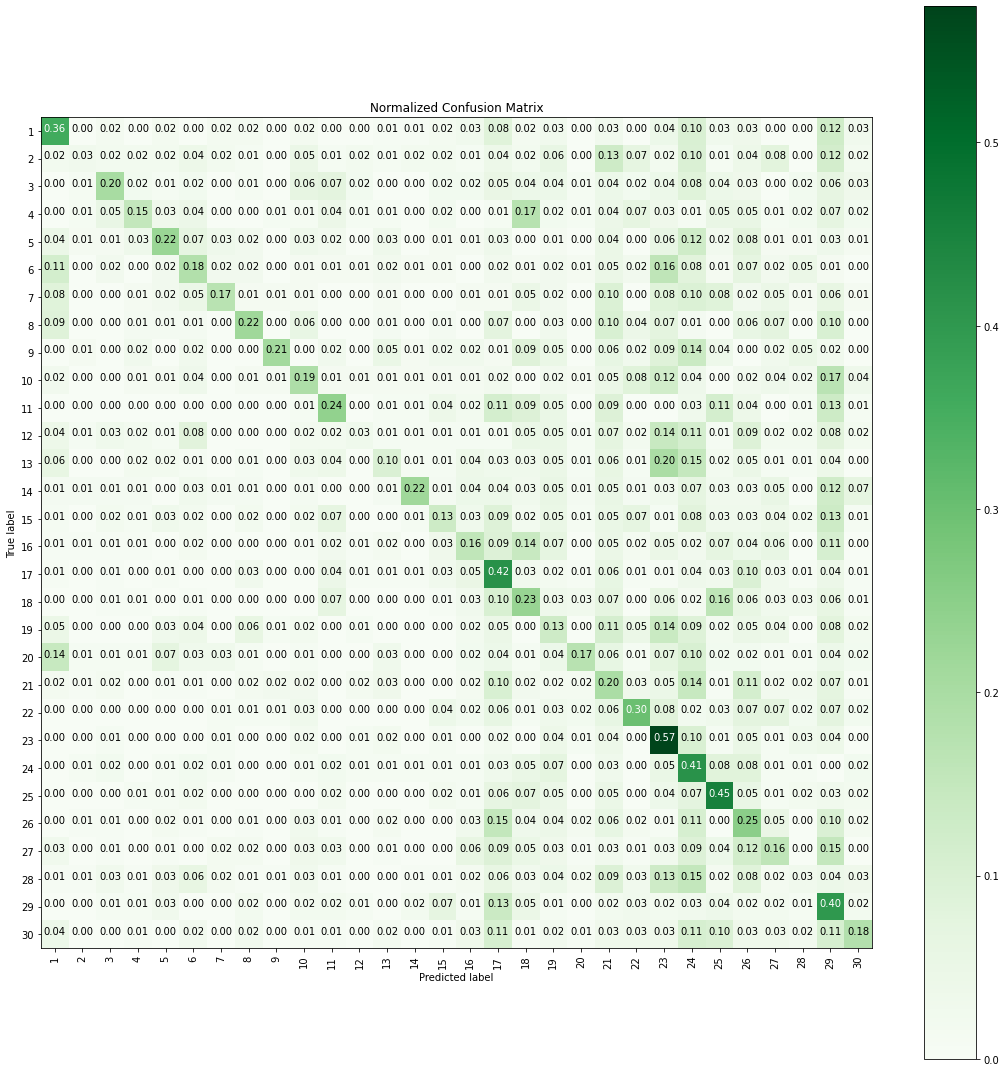


 F1 Score:0.217425284425719


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.21855719515268976
--------
n:  510
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:11.172979

Predicting test data
==> testing time:- 0:00:00.090746

==> Accuracy:- 0.2087298982605842


 ********Confusion Matrix********

 [[41  0  2  1  1  0  1  2  1  1  2  0  2  0  1  1 12  0  3  0  3  0  5 13
   3  2  2  0 18  3]
 [ 4 10  1  0  2  4  0  2  0  4  1  0  1  0  2  2  3  2  4  0 11  8  1 12
   1  7  4  1 15  1]
 [ 2  0 12  1  0  5  0  0  0  3  6  0  1  0  1  1  3  8  4  1  2  4 10  5
   4  5  3  1 10  3]
 [ 1  0  3 18  2  3  0  1  1  1  6  0  1  2  5  2  1  8  1  0  3  3  3  

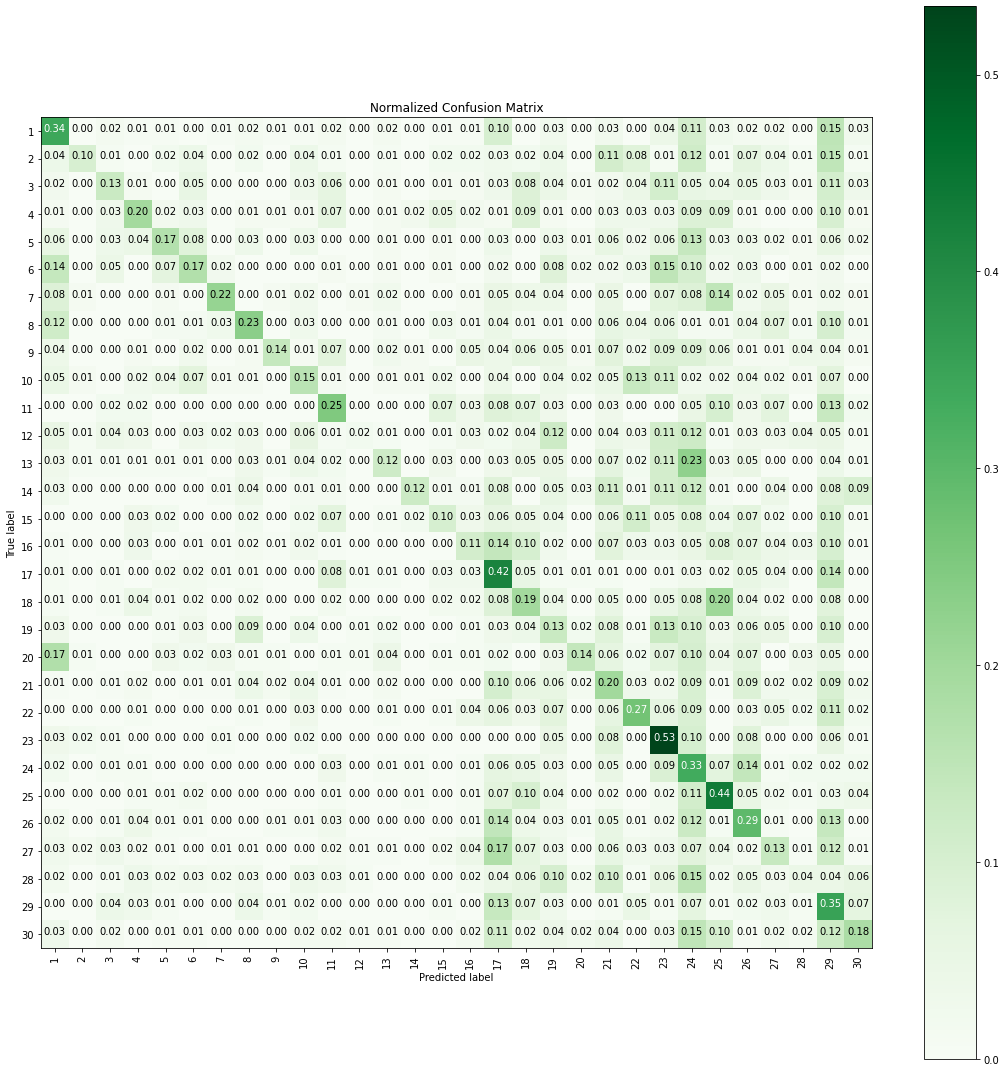


 F1 Score:0.2014663815763245


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.19592648846876662
--------
n:  520
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:49.603458

Predicting test data
==> testing time:- 0:00:00.130529

==> Accuracy:- 0.1588447653429603


 ********Confusion Matrix********

 [[27  1  2  0  3  0  1  6  0  2  0  0  4  0  1  4 12  4  5  0  3  2  7  9
   4  4  3  1 13  2]
 [ 3  6  1  0  3  1  2  2  1  3  2  3  0  1  2  1  3  1  6  0  6  7  3  9
   1 11  8  3 13  1]
 [ 3  1 14  4  3  3  0  1  0  6  3  0  0  0  2  2  4  5  6  1  5  3  1  3
   6  2  1  5  9  2]
 [ 0  3  4 13  2  3  1  1  1  1  4  1  0  0  3  2  2 13  3  1  0  2  0 

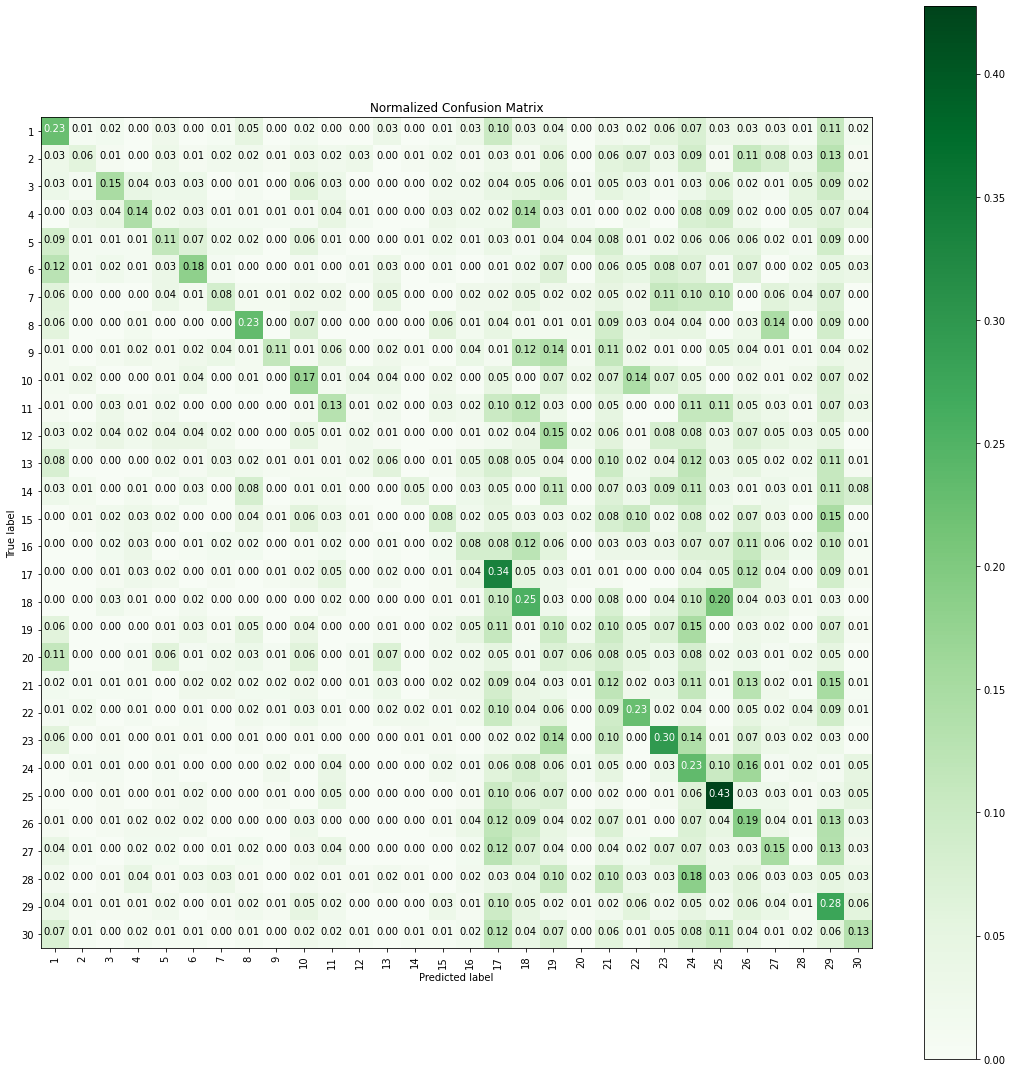


 F1 Score:0.15204986392945552


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.15616015609185285
--------
n:  530
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:30.871219

Predicting test data
==> testing time:- 0:00:00.090567

==> Accuracy:- 0.14374794880210043


 ********Confusion Matrix********

 [[28  0  0  0  4  0  1  5  0  2  0  0  4  0  2  1  9  0  9  0  5  1  5 10
   7  4  5  0 16  2]
 [ 6  0  1  2  0  2  1  2  2  2  2  0  1  1  1  1  2  1  9  0 12  8  3  5
   1 13  6  0 16  3]
 [ 3  0  6  0  1  0  0  0  0  2  7  0  0  0  1  2  5  8 12  0  1  5  5  8
   7  7  0  1 10  4]
 [ 1  0  2  8  1  0  0  0  0  1  8  0  2  0  0  1  2 16  7  0  2  2  

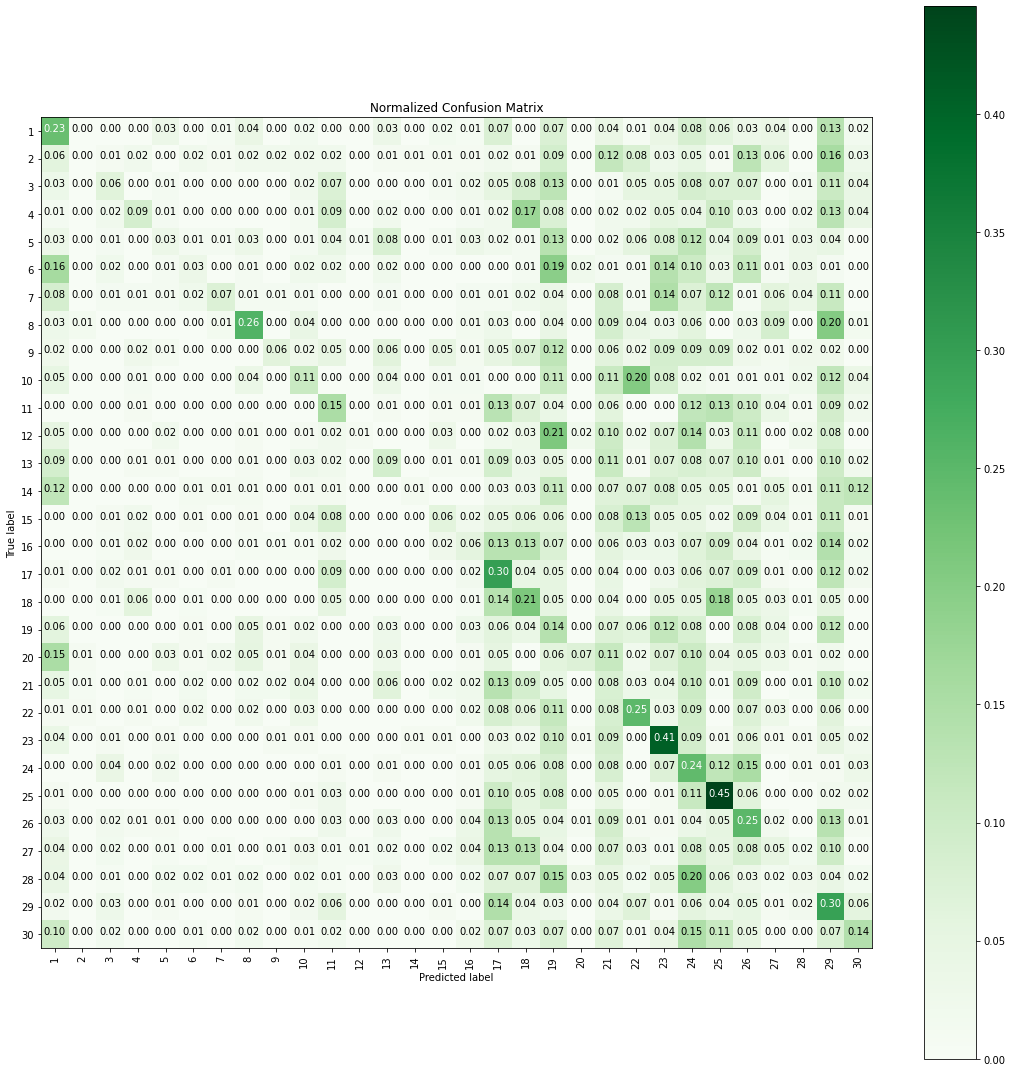


 F1 Score:0.12692237380176244


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.144681554075144
--------
n:  540
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:57.534401

Predicting test data
==> testing time:- 0:00:00.096796

==> Accuracy:- 0.12569740728585493


 ********Confusion Matrix********

 [[26  1  4  2  1  2  1  0  0  2  0  1  3  0  4  0 11  4  2  3  4  2  7  9
   8  5  5  1 12  0]
 [ 6  1  1  2  4  1  0  0  0  1  2  0  0  0  2  4  1  5  8  2  6  9  5 10
   0 14  2  1 15  1]
 [ 3  0  6  1  0  2  1  0  0  2  8  0  2  0  3  1  6  5  6  0  6  0  6  9
  12  6  0  0  9  1]
 [ 0  0  5  4  0  3  0  1  1  2 11  0  1  0  3  0  1 10  6  1  5  2  1  9

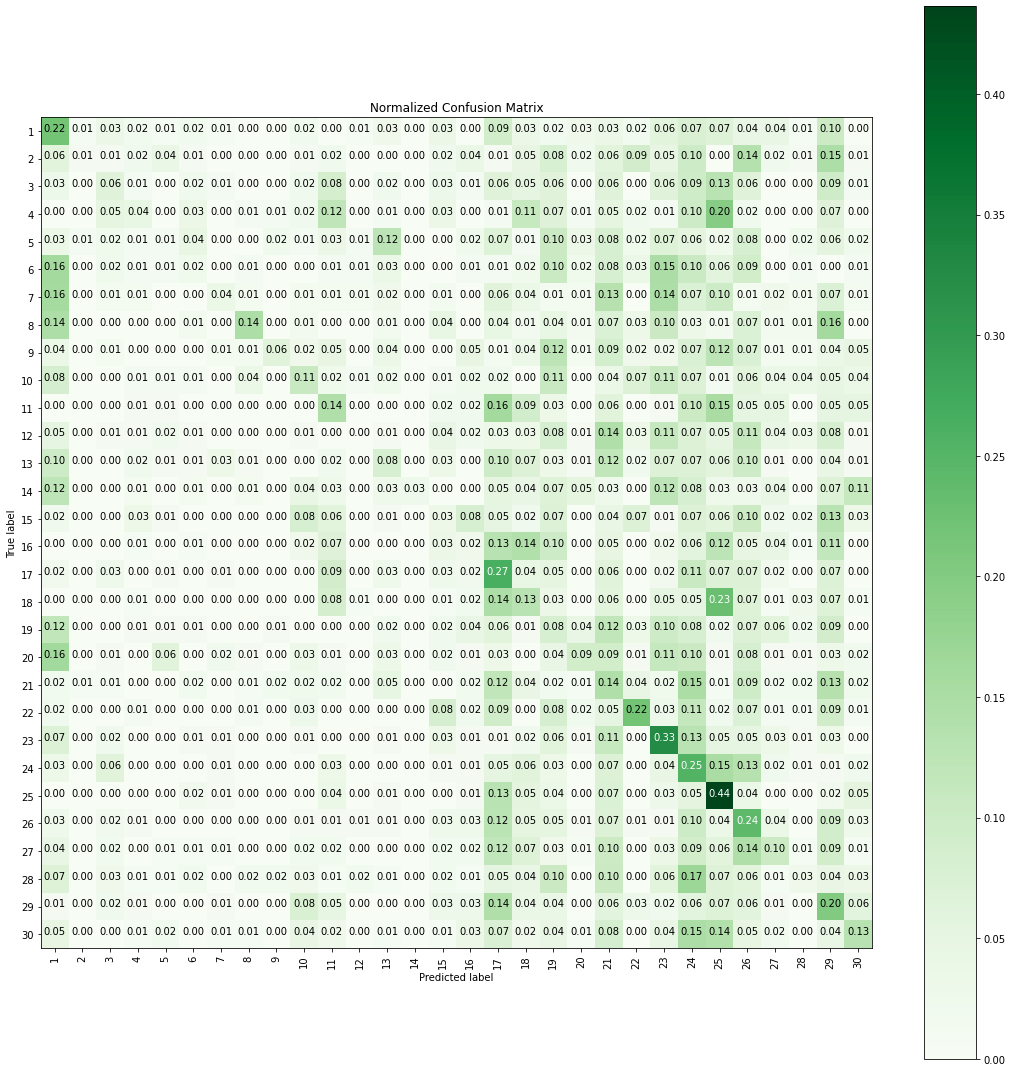


 F1 Score:0.10931335778918723


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.12835302983010383
--------
n:  550
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:49.242667

Predicting test data
==> testing time:- 0:00:00.178903

==> Accuracy:- 0.10764686576960945


 ********Confusion Matrix********

 [[21  1  1  2  1  3  2  3  1  4  0  2  4  0  2  4  6  4  4  1  2  1  7  5
  11  8  7  1 11  1]
 [ 7  1  1  0  2  1  1  1  1  1  1  1  4  1  5  1  5  7  2  1 10  3  4  8
   2  9  5  5 10  3]
 [ 3  0  5  2  0  0  1  0  0  2  5  1  2  0  1  6  1  4  0  2  6  0  8 13
  13  9  3  0  4  4]
 [ 0  1  4  1  0  0  0  2  0  3 10  2  1  0  3  1  1 12  3  0  4  1  

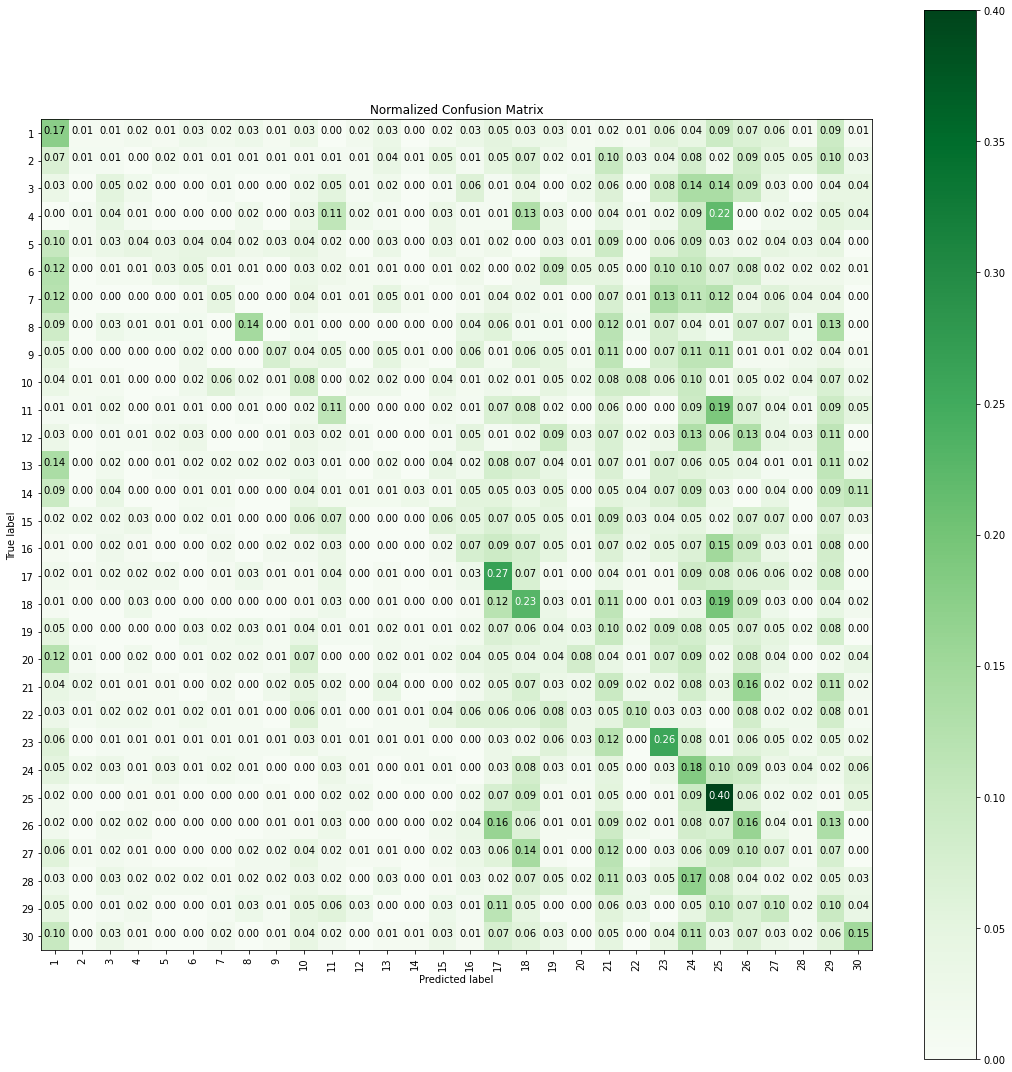


 F1 Score:0.09519924868897059


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11396755661137543
--------
n:  560
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:25.879458

Predicting test data
==> testing time:- 0:00:00.098126

==> Accuracy:- 0.08893994092550049


 ********Confusion Matrix********

 [[20  0  2  0  0  1  0  1  0  2  0  0  7  0  3  4  5  5  1  7  9  1  9  7
   9  4  7  1 12  3]
 [16  1  2  2  1  1  2  0  0  2  1  0  4  0  1  0  2  5  7  0 12  0  0 13
   5  8  4  2  7  5]
 [ 4  1  4  1  0  0  0  0  0  3  7  0  3  1  0  4  4  7  0  4  3  0  4  9
  15  9  3  0  7  2]
 [ 4  0  5  2  1  1  2  0  0  1 11  0  1  1  1  0  3 16  3  0  3  1  

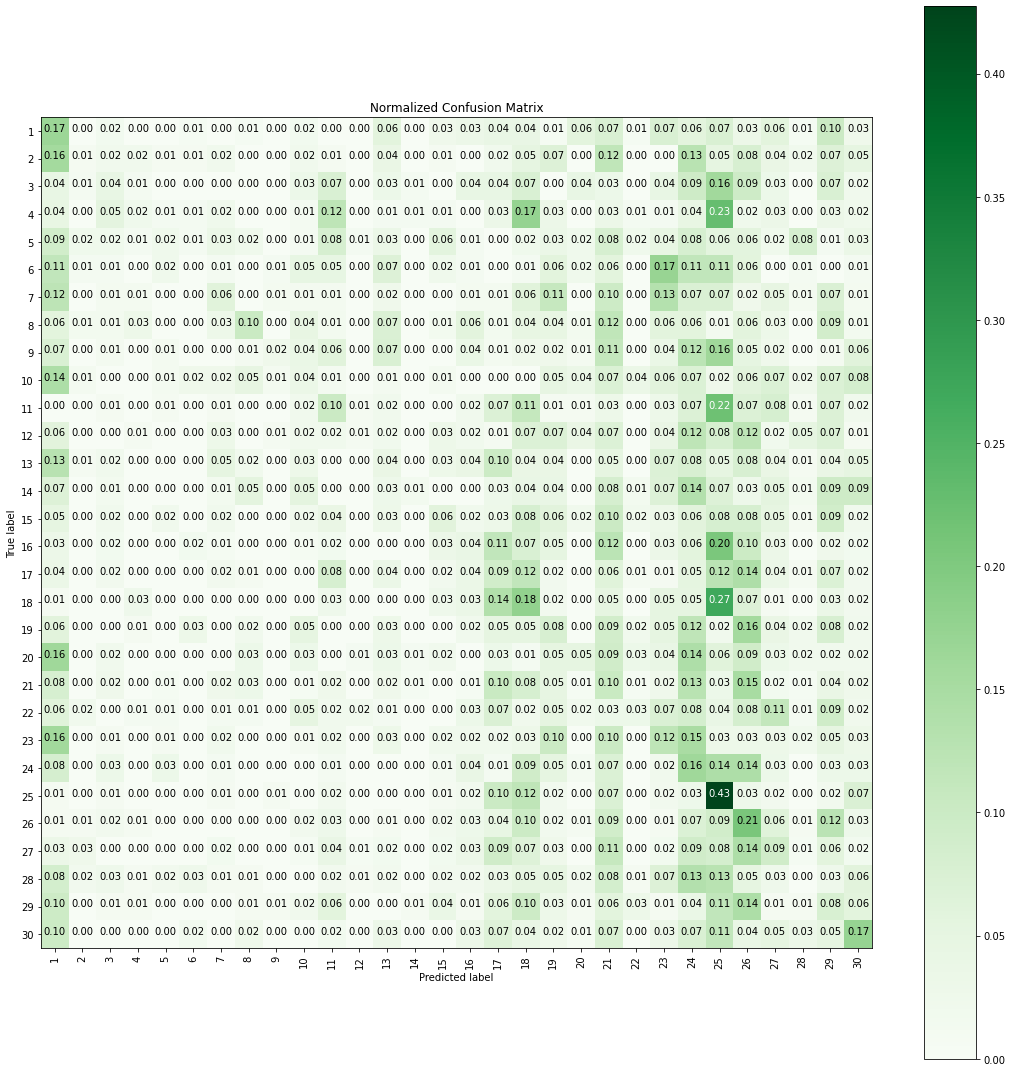


 F1 Score:0.07304479718134356


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09747695908204618
--------
n:  570
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:01.697483

Predicting test data
==> testing time:- 0:00:00.102684

==> Accuracy:- 0.0863144076140466


 ********Confusion Matrix********

 [[18  0  1  0  0  0  2  2  1  7  1  0  6  1  4  4 10  3  4  2  4  1  2  4
   7 12  2  3 15  4]
 [10  4  0  1  1  1  3  0  1  3  4  0  2  0  1  2  4 12  2  1  2  3  0  8
   3 12  4  4 11  4]
 [ 3  1  2  3  3  1  3  1  1  2  3  2  1  0  2  5  0  2  6  0  5  1  2 10
  17  6  2  3  7  1]
 [ 2  1  1  1  0  1  0  0  0  2  7  1  1  1  1  1  1 12  4  0  3  0  3

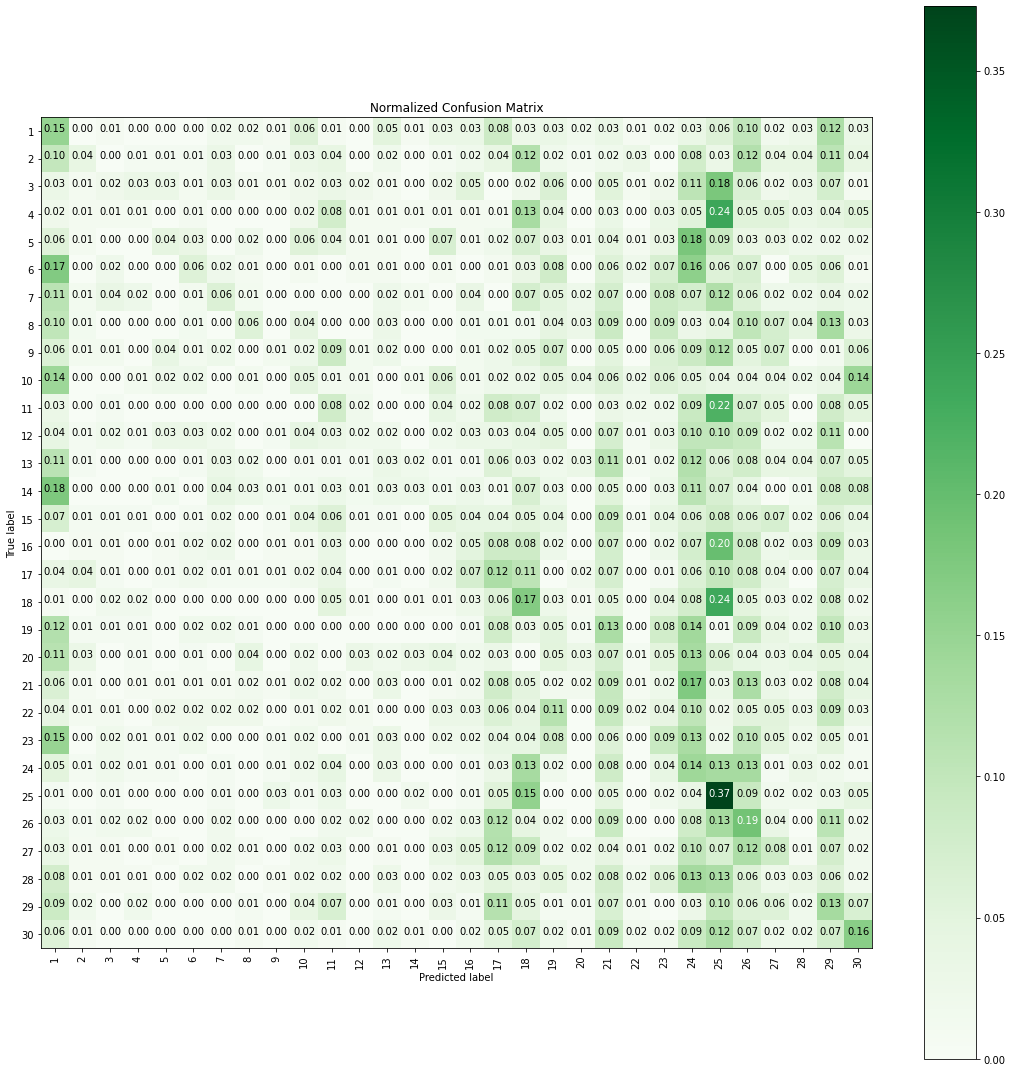


 F1 Score:0.07318048955991265


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.08923499059034638
--------
n:  580
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:12.478468

Predicting test data
==> testing time:- 0:00:00.097866

==> Accuracy:- 0.07679684936002626


 ********Confusion Matrix********

 [[22  0  2  0  1  1  0  0  0  0  1  0  8  1  0  5  9  4  0  1 11  1  6  8
   8  6  8  1 11  5]
 [13  5  2  0  0  0  2  1  1  2  0  1  1  1  0  2  2  9  1  0  8  0  2 12
  11 12  6  1  6  2]
 [10  2  2  1  2  1  0  0  1  0  4  1  1  0  2  1  2  9  4  0  4  1  5  8
  19  5  1  3  5  1]
 [ 4  0  1  1  2  0  3  1  0  1  4  2  0  0  0  4  1 11  1  0  2  0  

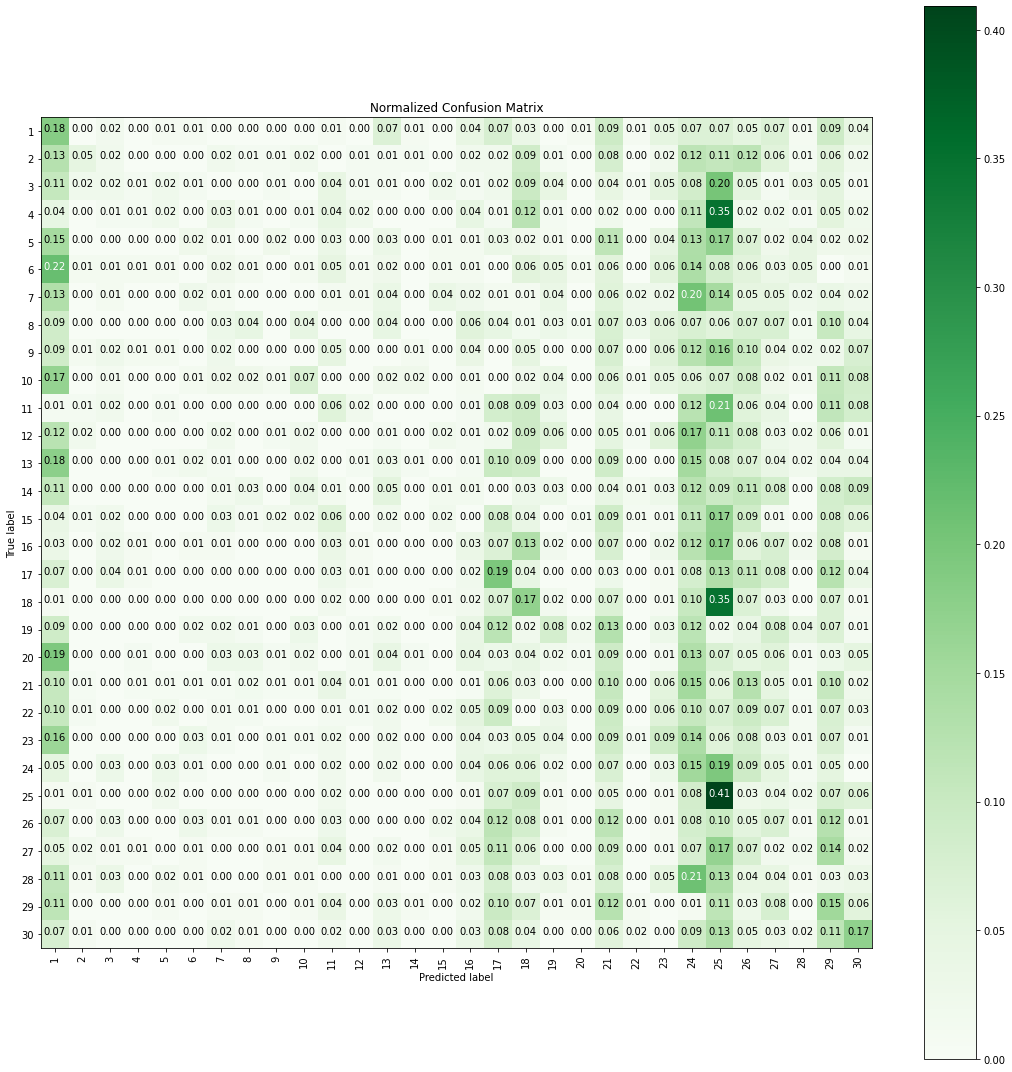


 F1 Score:0.05792498688271246


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.083898717910208
--------
n:  590
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:07:28.442198

Predicting test data
==> testing time:- 0:00:00.139605

==> Accuracy:- 0.08040695766327535


 ********Confusion Matrix********

 [[20  0  1  0  0  1  2  1  1  3  0  0  3  0  2  3  5  3  0  1  7  3  7  5
  12 17  7  3 11  2]
 [14  5  1  1  2  1  1  0  0  3  4  2  1  0  2  5  0  8  2  0  6  0  4 11
   6  8  5  2  9  0]
 [ 7  3  5  0  1  0  1  1  1  2  5  0  2  0  0  3  4  8  1  3  5  0  3 11
  18  8  1  0  1  1]
 [ 4  0  4  1  0  0  0  0  0  1  5  1  3  0  0  1  1  9  1  0  6  0  0 

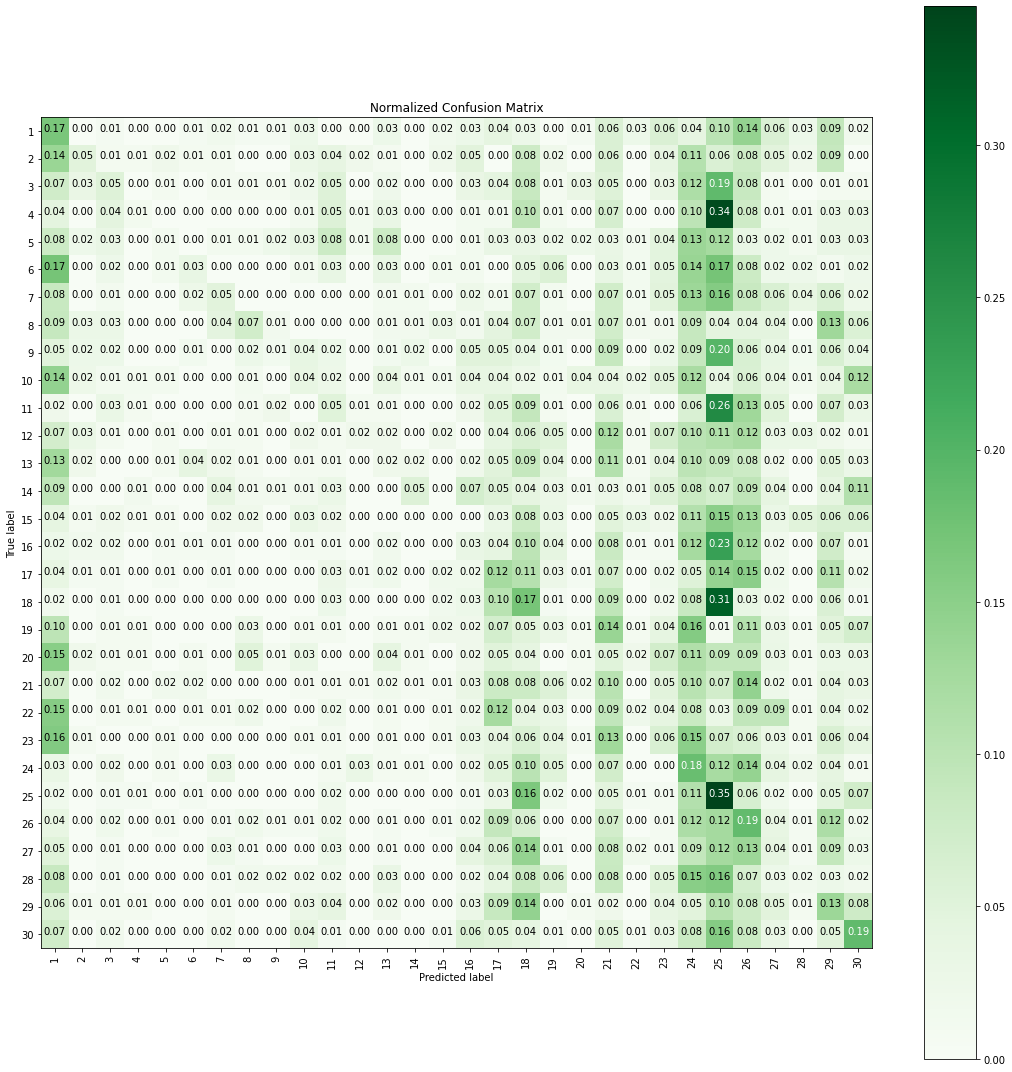


 F1 Score:0.06534236886656267


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.08406079119449708
--------
n:  600
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:28.812261

Predicting test data
==> testing time:- 0:00:00.082984

==> Accuracy:- 0.07056120774532326


 ********Confusion Matrix********

 [[30  0  0  0  1  1  1  0  0  1  2  0  3  0  0  4  8  3  1  0  7  1  2 11
  12 11  3  0 11  7]
 [20  3  1  0  0  0  1  0  0  2  0  0  1  0  2  2  4  6  0  0 10  1  0 14
  15  7  4  0  5  5]
 [13  0  2  0  1  1  0  1  0  0  4  0  0  0  1  0  2  3  0  0  2  1  1 16
  29  7  2  1  6  2]
 [ 8  0  1  0  0  0  0  0  0  0  3  1  0  0  2  2  2  6  0  0  3  1  

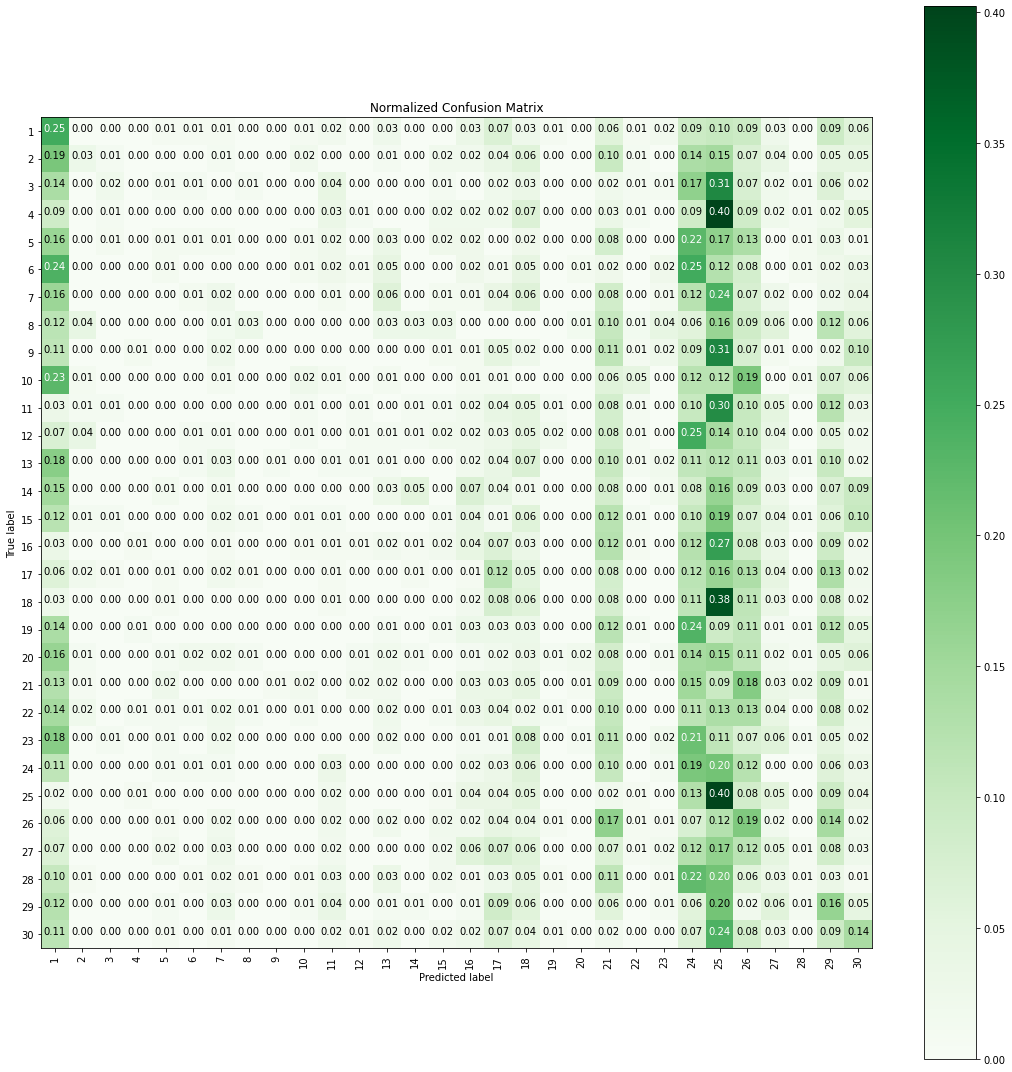


 F1 Score:0.04845632702523501


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.07484625239812302
--------
n:  610
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:27.191110

Predicting test data
==> testing time:- 0:00:00.109759

==> Accuracy:- 0.05612077453232688


 ********Confusion Matrix********

 [[13  1  1  2  1  2  3  0  0  3  1  0  2  0  2  2  8  1  0  0 10  0  0  6
  17 16 10  1  8 10]
 [ 9  2  1  1  0  1  1  0  0  4  1  1  2  0  1  2  1  8  2  0  5  2  0 11
  18 10  8  2  8  2]
 [11  0  2  0  0  0  1  0  0  4  1  1  5  1  1  0  1  6  1  0  5  0  0  4
  25 10  4  1  6  5]
 [ 9  1  0  0  1  1  3  1  0  0  0  2  1  1  3  2  1  8  0  0  4  0  

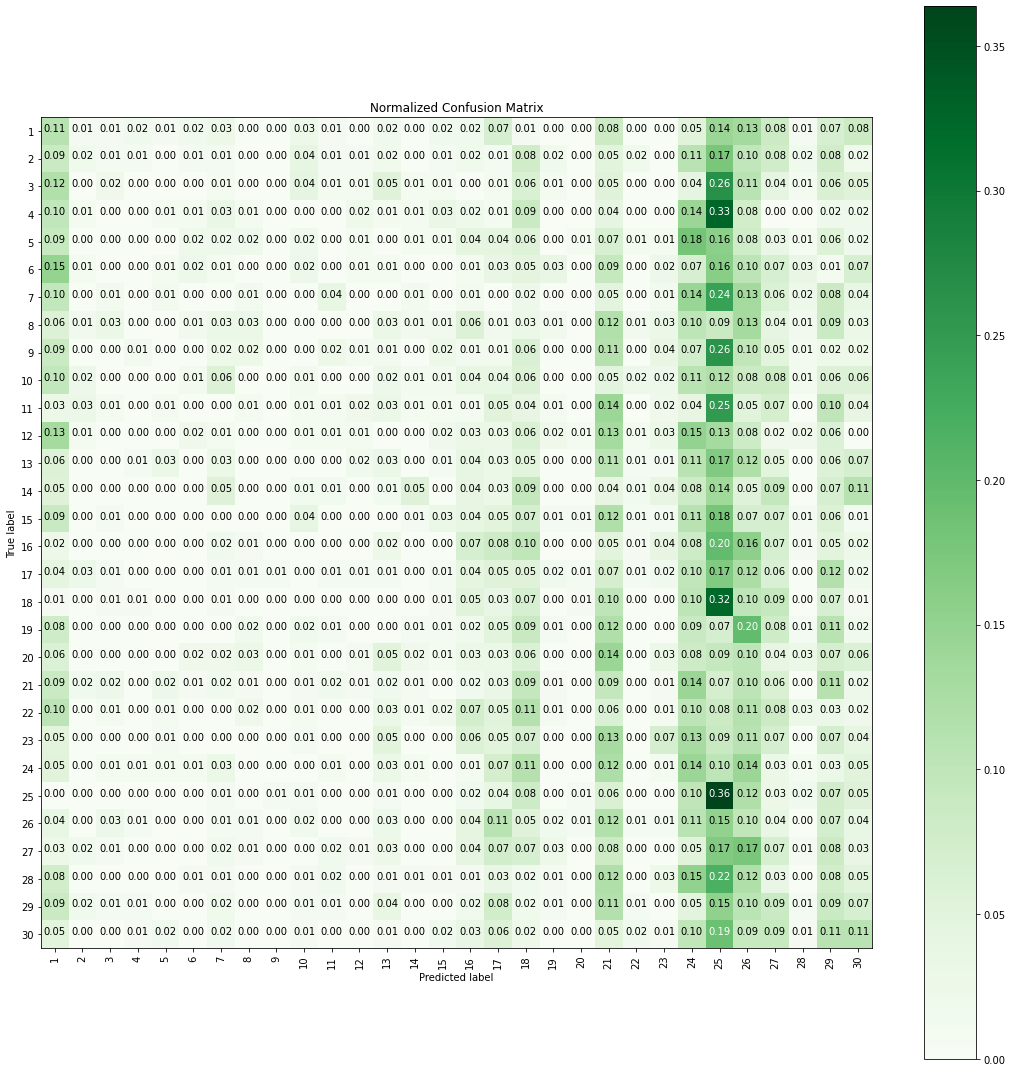


 F1 Score:0.041738615974824804


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=120)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 120}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.0641769720113412
--------
n:  620
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:37.601524

Predicting test data
==> testing time:- 0:00:00.105126

==> Accuracy:- 0.05415162454873646


 ********Confusion Matrix********

 [[10  3  0  0  1  0  1  0  0  1  1  0  0  1  1  3  4  7  0  0  8  1  1 14
  25 16  5  2 10  5]
 [10  2  0  0  0  0  1  2  0  1  0  1  1  1  3  3  3  5  1  1 10  2  1  9
  16 12  7  0  8  3]
 [ 7  1  2  0  0  0  2  0  0  1  1  0  2  0  3  4  2  6  2  0  3  2  3 15
  16 14  4  0  1  4]
 [ 6  2  2  0  1  0  0  1  0  1  1  0  0  2  2  0  2  6  0  0  2  0  

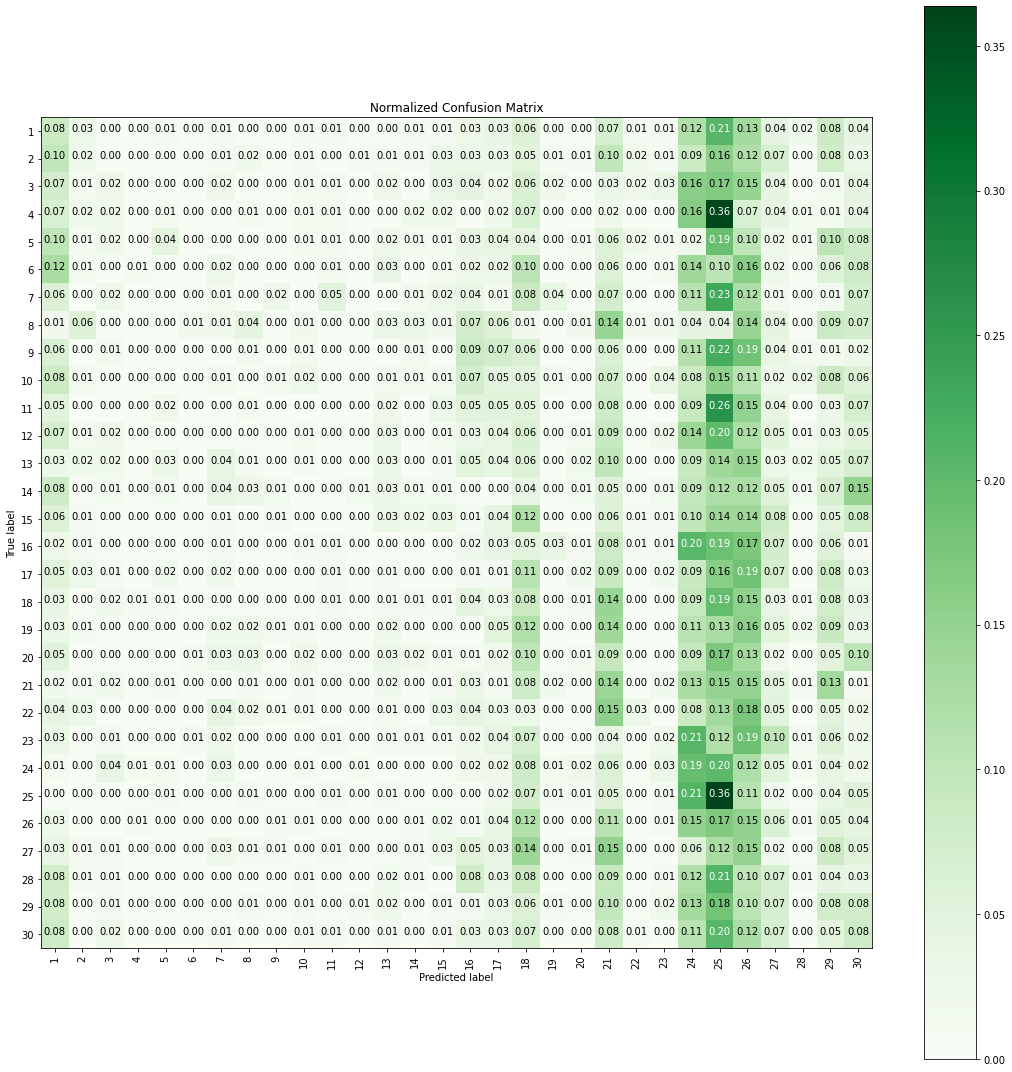


 F1 Score:0.037974879334201427


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.054155462365956517
--------
n:  630
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:50.550862

Predicting test data
==> testing time:- 0:00:00.102720

==> Accuracy:- 0.042336724647193964


 ********Confusion Matrix********

 [[ 2  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  2  6  0  0 11  0  4 21
  20 44  2  0  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  2  4  4  0  0 10  0  1 10
  17 44  5  0  2  3]
 [ 0  0  1  0  0  0  1  0  0  0  0  0  0  0  1  5  7  5  0  0  4  0  1 18
  13 28  5  1  1  4]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  3  4  0  0  7  

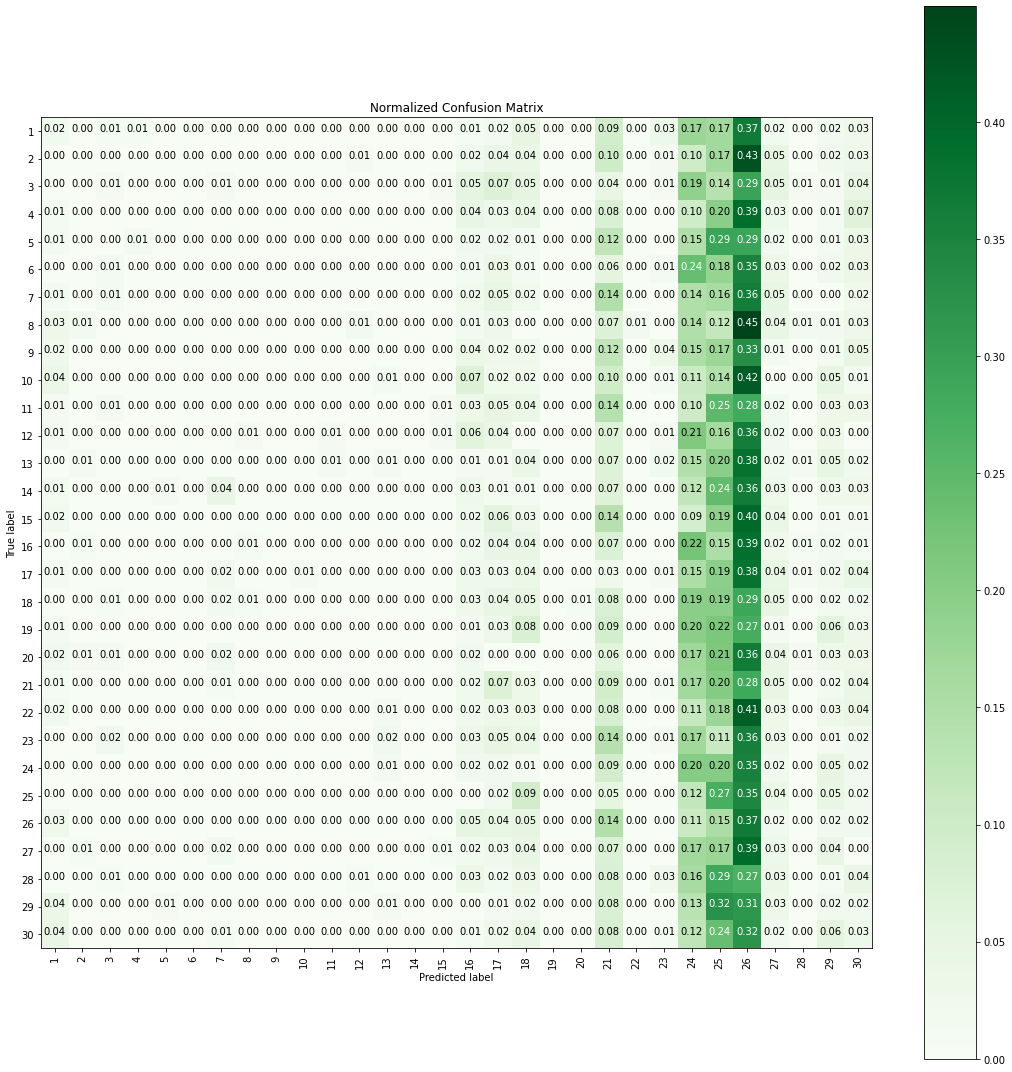


 F1 Score:0.018887484441207268


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.05221437032374171
--------
n:  640
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:44.057761

Predicting test data
==> testing time:- 0:00:00.082055

==> Accuracy:- 0.03380374138496882


 ********Confusion Matrix********

 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  4  4  0  1 12  0  1 26
  18 38  8  0  3  2]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  1  1  2  6  1  0  9  0  0 14
  18 33  6  0  7  3]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2  3  6  0  0  6  0  0 19
  14 35  4  0  2  2]
 [ 0  0  1  0  0  0  0  0  0  2  0  0  0  0  0  1  5  5  0  0  3  0  0

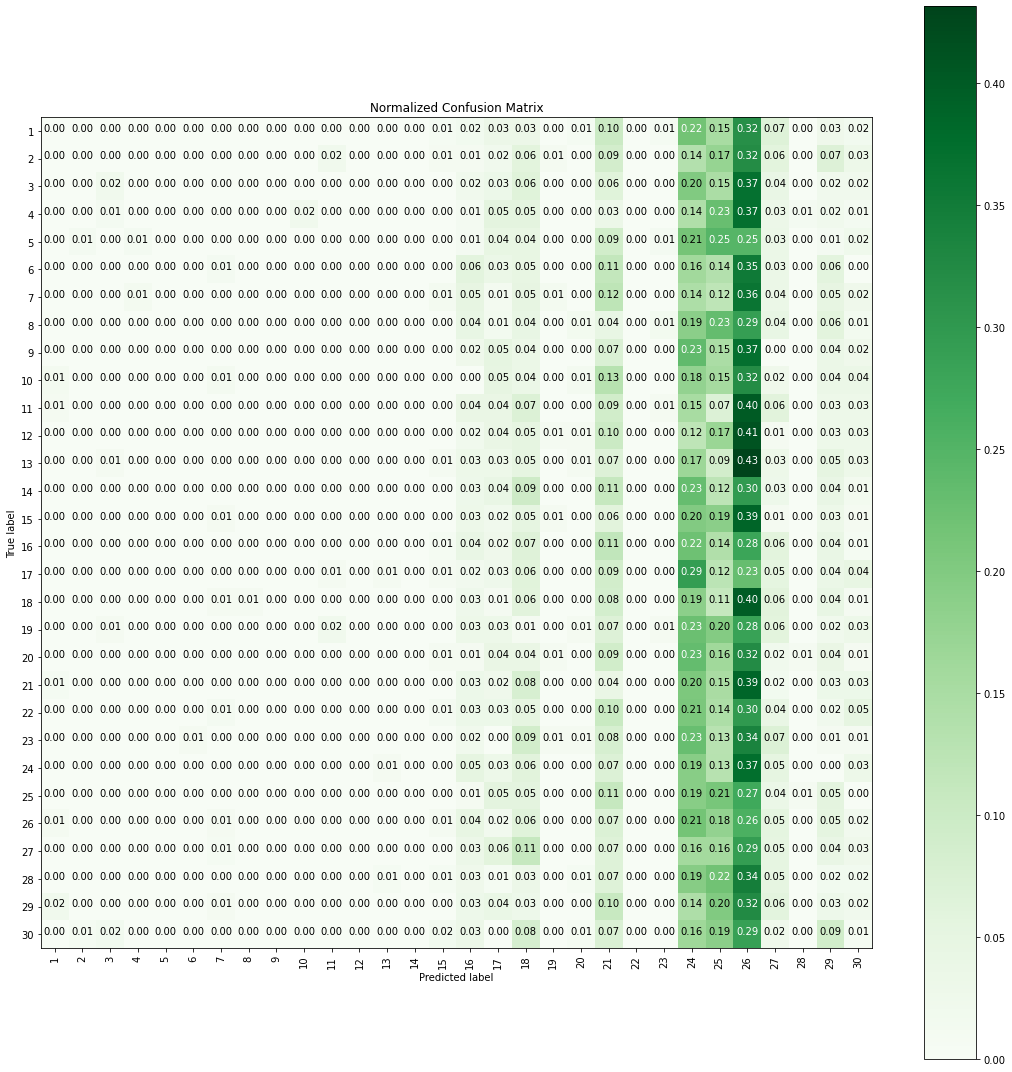


 F1 Score:0.015476139177755543


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.046233983672520546


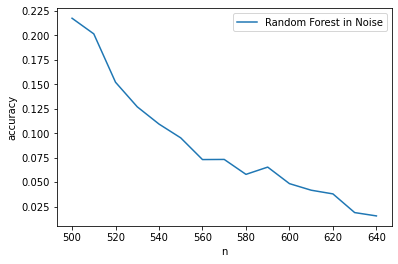

In [58]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
f1_array_random_uid = list()


n_array = np.arange(500, 650, 10)

for n in n_array:

  print('--------')
  print('n:  '+ str(n))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col in features_uid[:n]:
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  
  params = {'n_estimators': np.arange(110,151,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_array, f1_array_random_uid, label='Random Forest in Noise')
ax.set_xlabel('n')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


## HAR

--------
n:  500
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:03:48.368024

Predicting test data
==> testing time:- 0:00:00.082007

==> Accuracy:- 0.6832950443058746


 ********Confusion Matrix********

 [[443  42  56   0   0   0]
 [ 73 367  52   0   0   0]
 [ 37  66 325   0   0   0]
 [  0   0   0 246 119 141]
 [  0   0   0  98 344  91]
 [  0   0   0  95  95 357]]


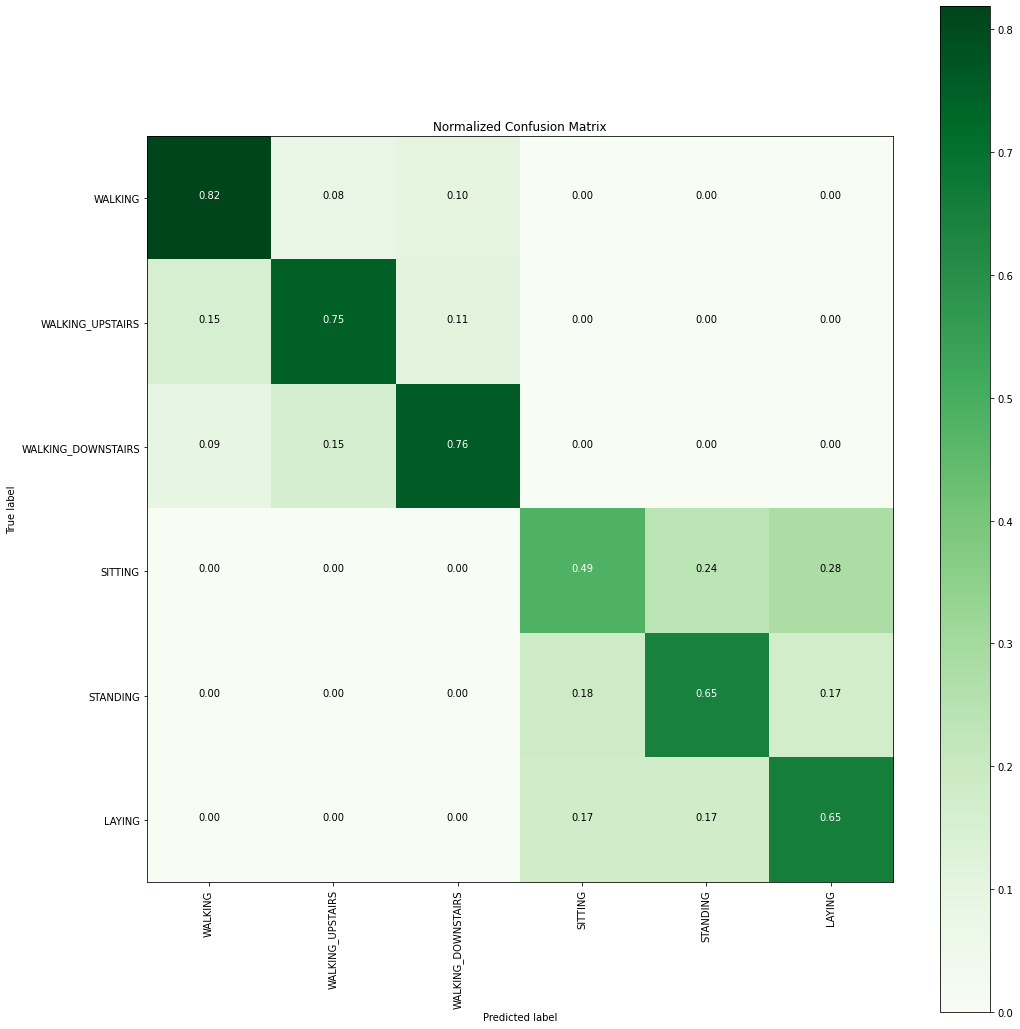


 F1 Score:0.6839378194759625


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6800824862903763
--------
n:  510
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:00.822823

Predicting test data
==> testing time:- 0:00:00.099677

==> Accuracy:- 0.6675418444371513


 ********Confusion Matrix********

 [[436  46  59   0   0   0]
 [ 91 356  45   0   0   0]
 [ 47  59 322   0   0   0]
 [  0   0   0 219 146 141]
 [  0   0   0  99 340  94]
 [  0   0   0  80 106 361]]


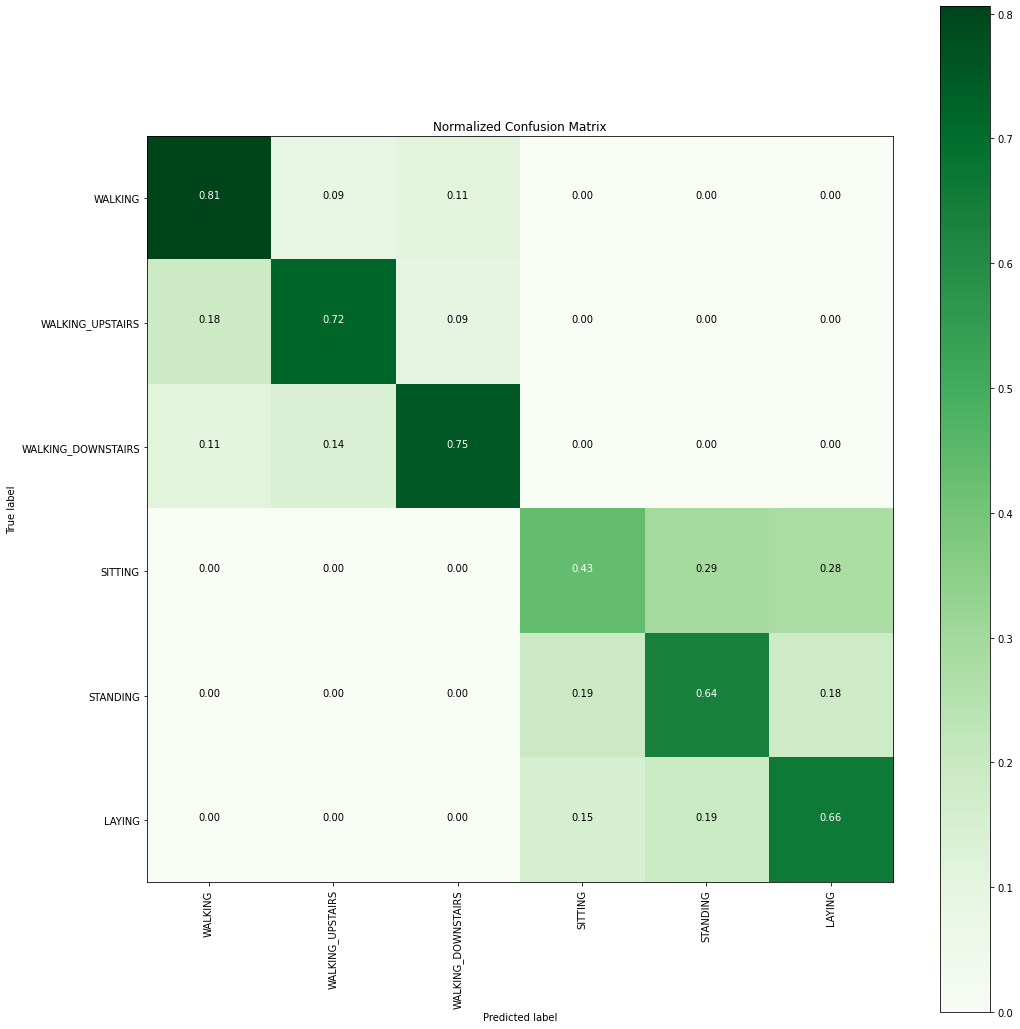


 F1 Score:0.6673173794135345


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.662624281216085
--------
n:  520
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:14.719378

Predicting test data
==> testing time:- 0:00:00.097681

==> Accuracy:- 0.6586806695109945


 ********Confusion Matrix********

 [[414  49  78   0   0   0]
 [ 98 349  45   0   0   0]
 [ 37  61 330   0   0   0]
 [  0   0   0 216 136 154]
 [  0   0   0  95 346  92]
 [  0   0   0 102  93 352]]


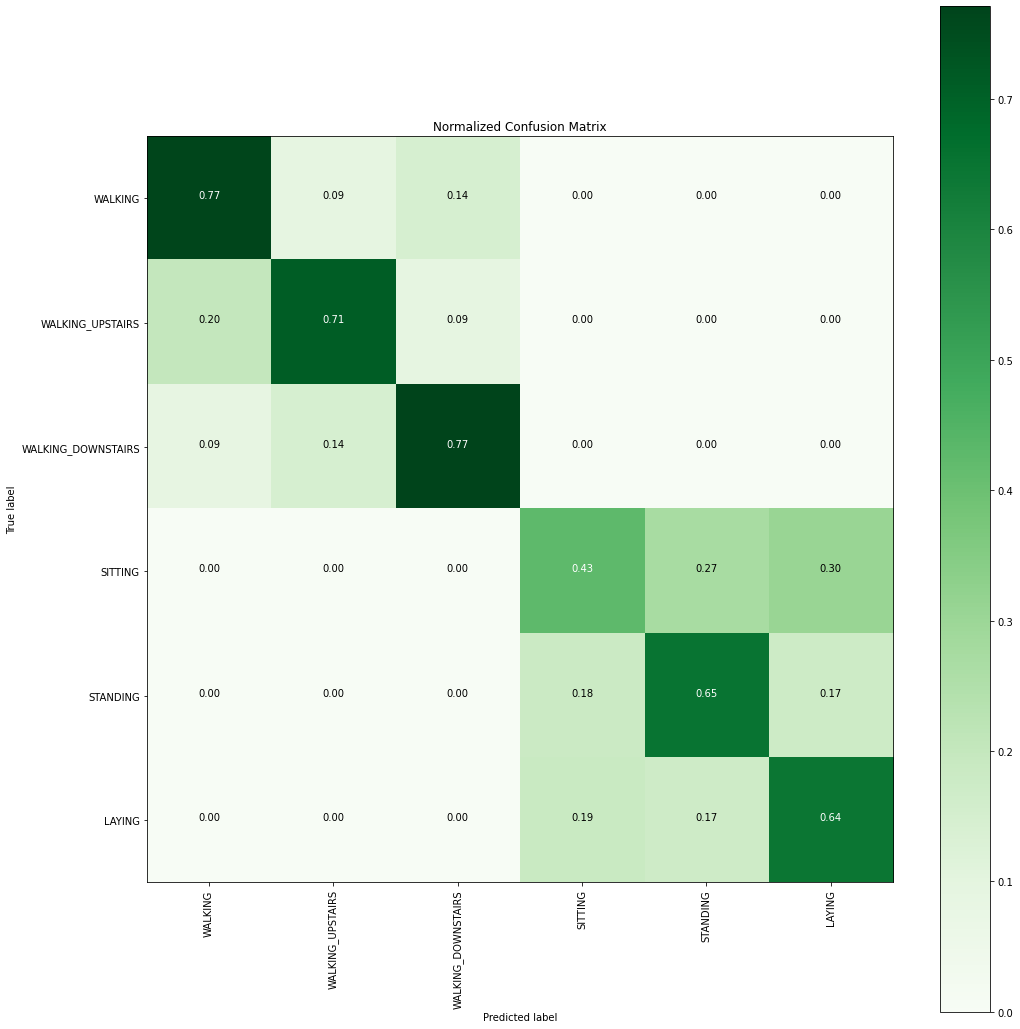


 F1 Score:0.6587030063552991


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=120)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 120}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6598777855121372
--------
n:  530
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:03:57.683916

Predicting test data
==> testing time:- 0:00:00.092746

==> Accuracy:- 0.6508040695766327


 ********Confusion Matrix********

 [[411  66  64   0   0   0]
 [126 322  44   0   0   0]
 [ 50  60 318   0   0   0]
 [  0   0   0 225 149 132]
 [  0   0   0  84 369  80]
 [  0   0   0  97 112 338]]


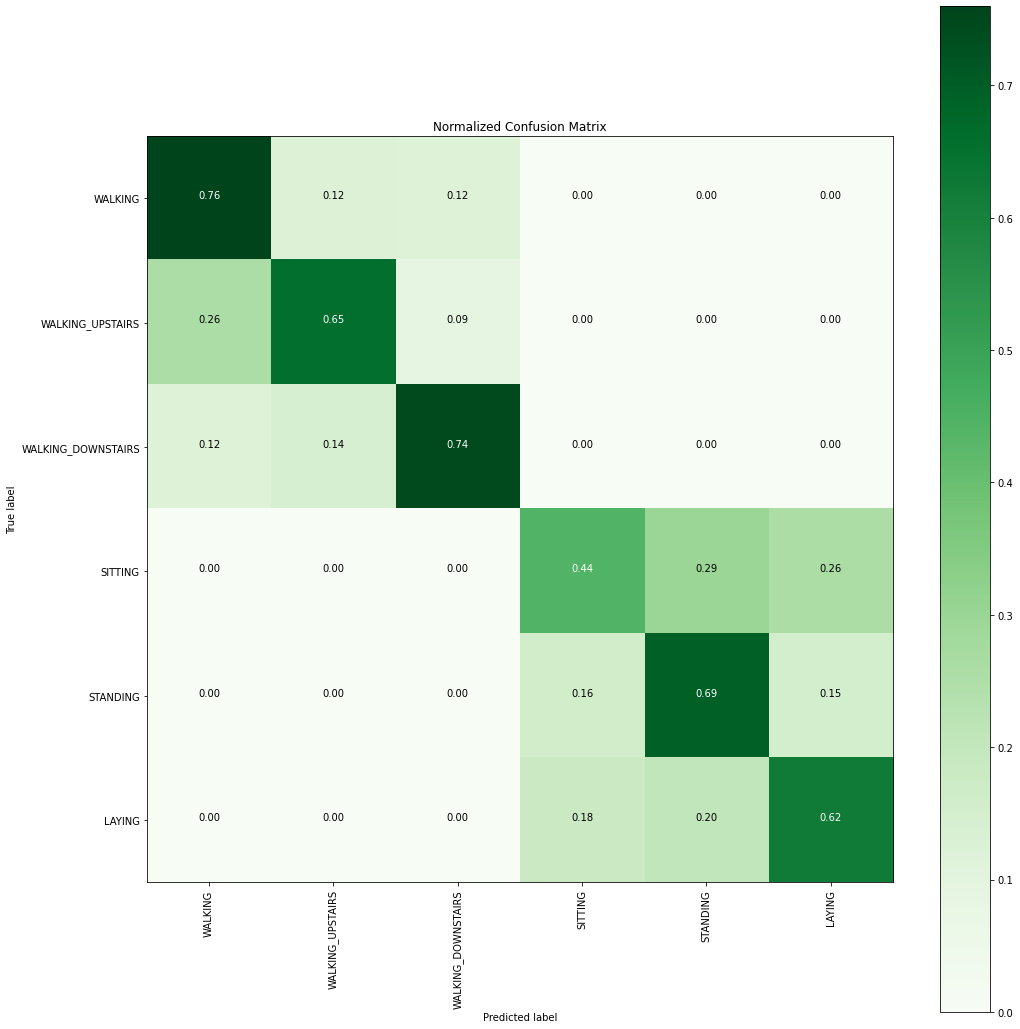


 F1 Score:0.6504622280475783


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6511477687824131
--------
n:  540
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:03:53.026691

Predicting test data
==> testing time:- 0:00:00.091590

==> Accuracy:- 0.6242205447981621


 ********Confusion Matrix********

 [[395  79  67   0   0   0]
 [121 327  44   0   0   0]
 [ 92  75 261   0   0   0]
 [  0   0   0 205 155 146]
 [  0   0   0  84 367  82]
 [  0   0   0  95 105 347]]


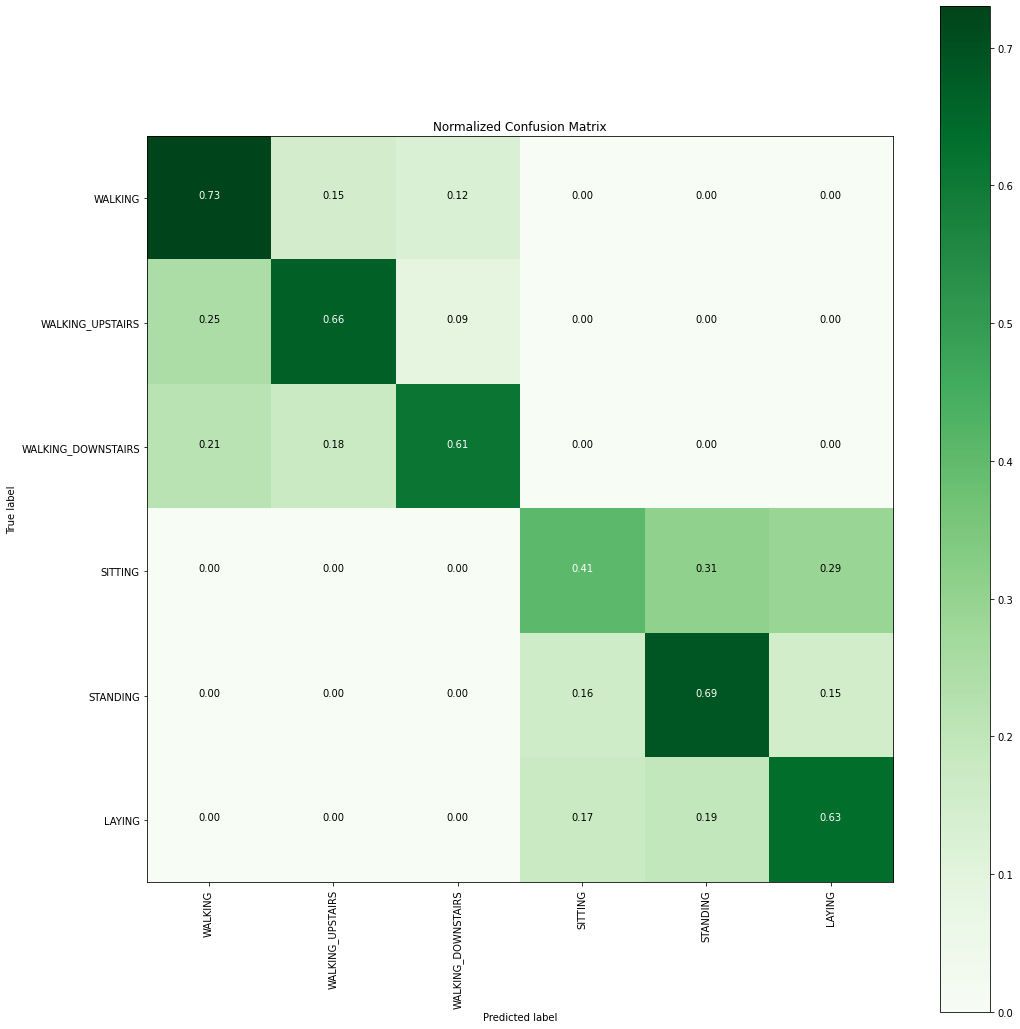


 F1 Score:0.6206955822381505


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6188155198556098
--------
n:  550
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:00.843767

Predicting test data
==> testing time:- 0:00:00.088981

==> Accuracy:- 0.615687561535937


 ********Confusion Matrix********

 [[403  82  56   0   0   0]
 [149 296  47   0   0   0]
 [104  67 257   0   0   0]
 [  0   0   0 216 148 142]
 [  0   0   0  98 358  77]
 [  0   0   0  95 106 346]]


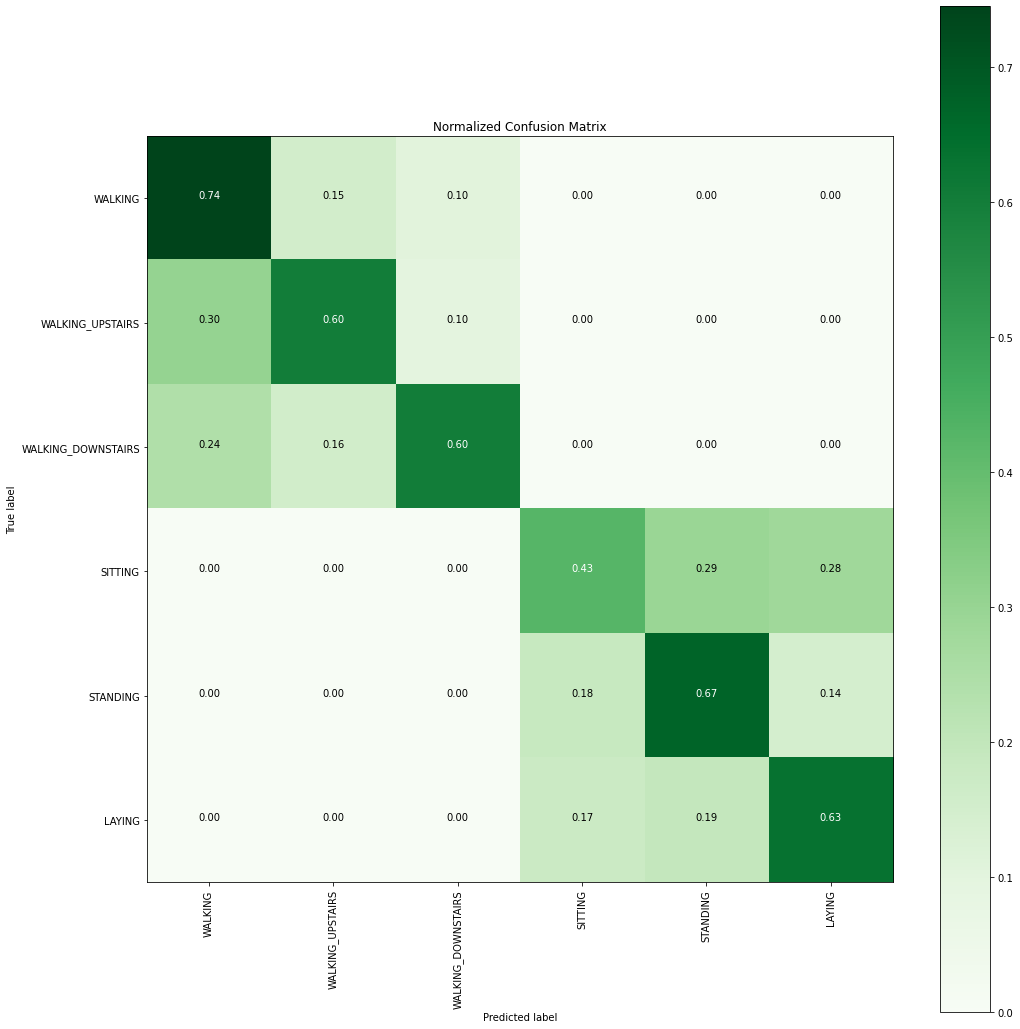


 F1 Score:0.6128664585106337


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6150969762427468
--------
n:  560
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:13.827579

Predicting test data
==> testing time:- 0:00:00.102906

==> Accuracy:- 0.6051854282901215


 ********Confusion Matrix********

 [[420  92  29   0   0   0]
 [174 278  40   0   0   0]
 [134  72 222   0   0   0]
 [  0   0   0 206 149 151]
 [  0   0   0  91 358  84]
 [  0   0   0  79 108 360]]


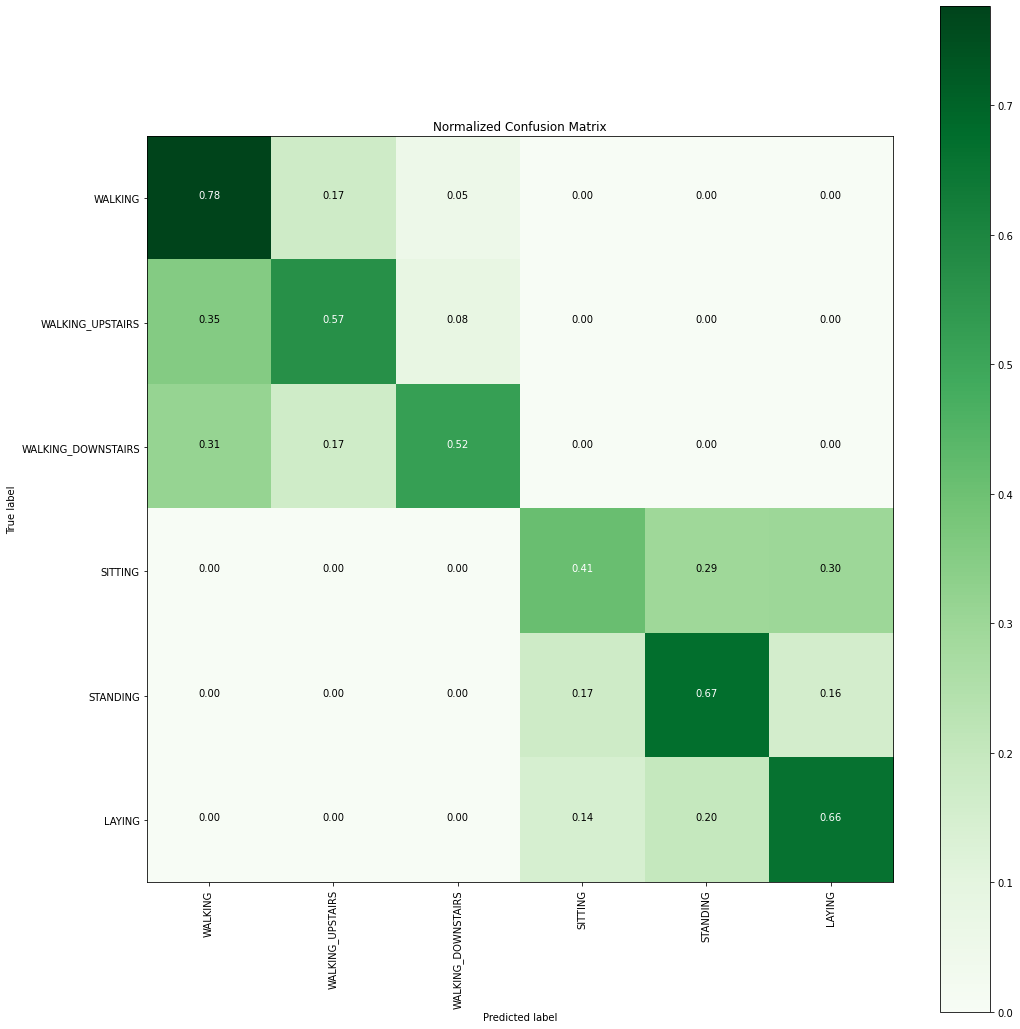


 F1 Score:0.599339728117687


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6091185485756226
--------
n:  570
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:21.902967

Predicting test data
==> testing time:- 0:00:00.083867

==> Accuracy:- 0.5713816869051526


 ********Confusion Matrix********

 [[378 110  53   0   0   0]
 [201 254  37   0   0   0]
 [170  68 190   0   0   0]
 [  0   0   0 194 147 165]
 [  0   0   0  97 343  93]
 [  0   0   0  92  73 382]]


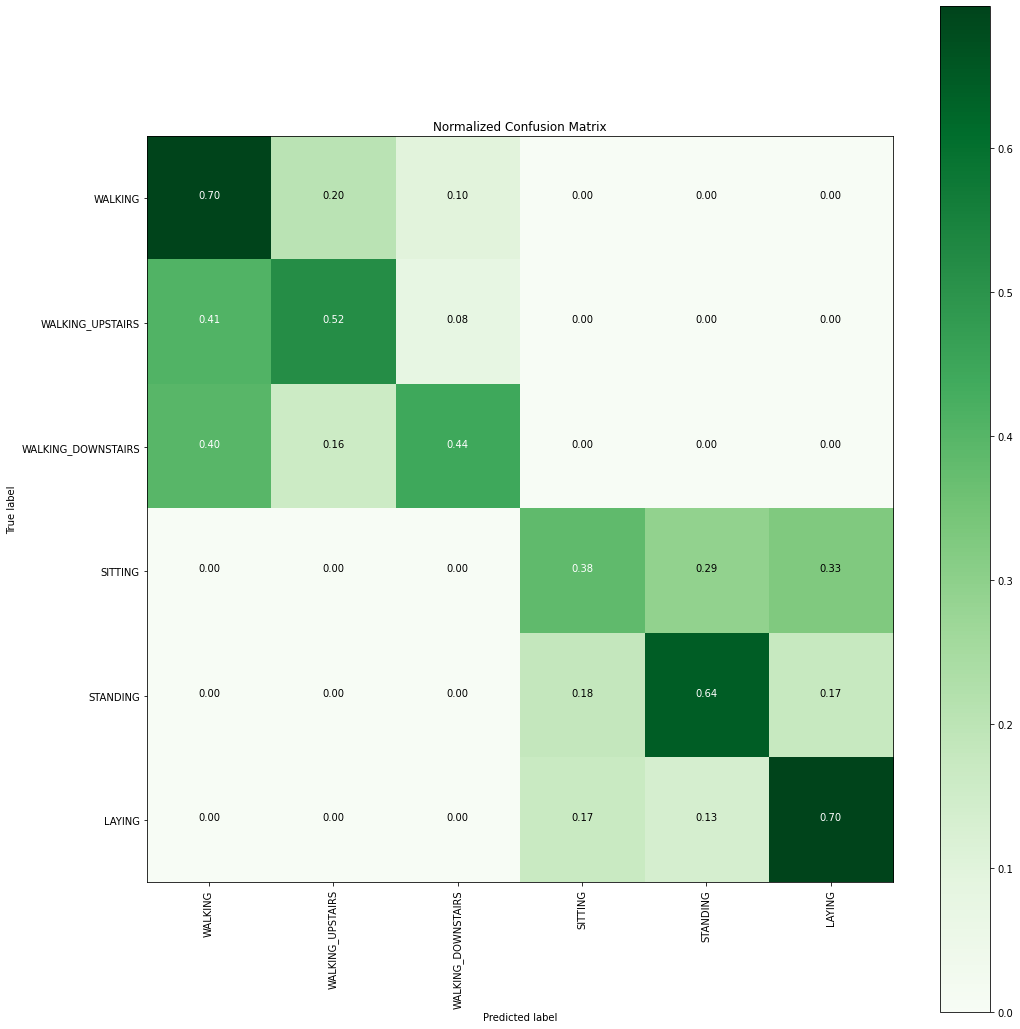


 F1 Score:0.5630917509098434


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=120)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 120}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5835780975130044
--------
n:  580
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:21.829528

Predicting test data
==> testing time:- 0:00:00.071672

==> Accuracy:- 0.5753199868723334


 ********Confusion Matrix********

 [[406 112  23   0   0   0]
 [220 253  19   0   0   0]
 [192  80 156   0   0   0]
 [  0   0   0 169 166 171]
 [  0   1   0  75 366  91]
 [  0   0   0  58  86 403]]


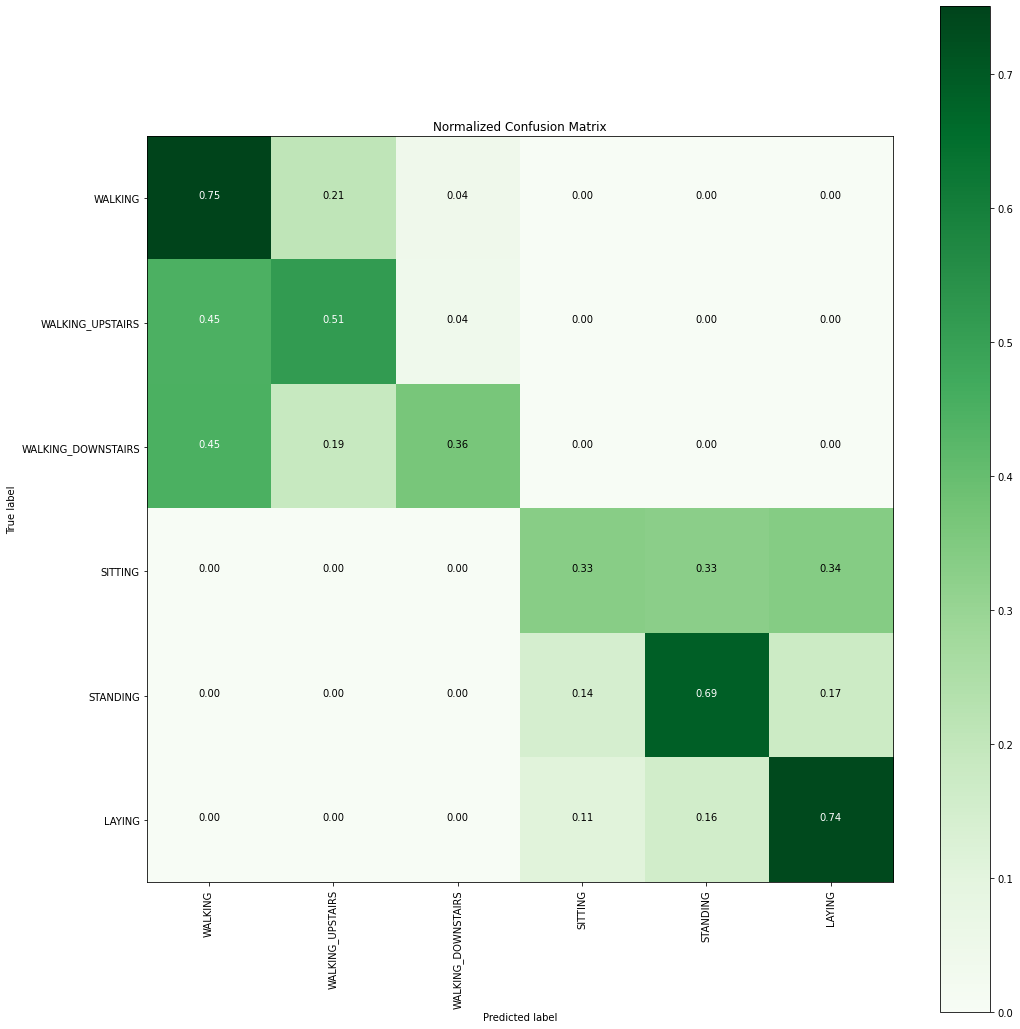


 F1 Score:0.5591080669172513


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5717763937192358
--------
n:  590
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:18.064511

Predicting test data
==> testing time:- 0:00:00.087185

==> Accuracy:- 0.5388907121759108


 ********Confusion Matrix********

 [[399 110  32   0   0   0]
 [213 250  29   0   0   0]
 [205  71 152   0   0   0]
 [  0   0   0 150 183 173]
 [  0   0   0  78 354 101]
 [  0   0   0  73 137 337]]


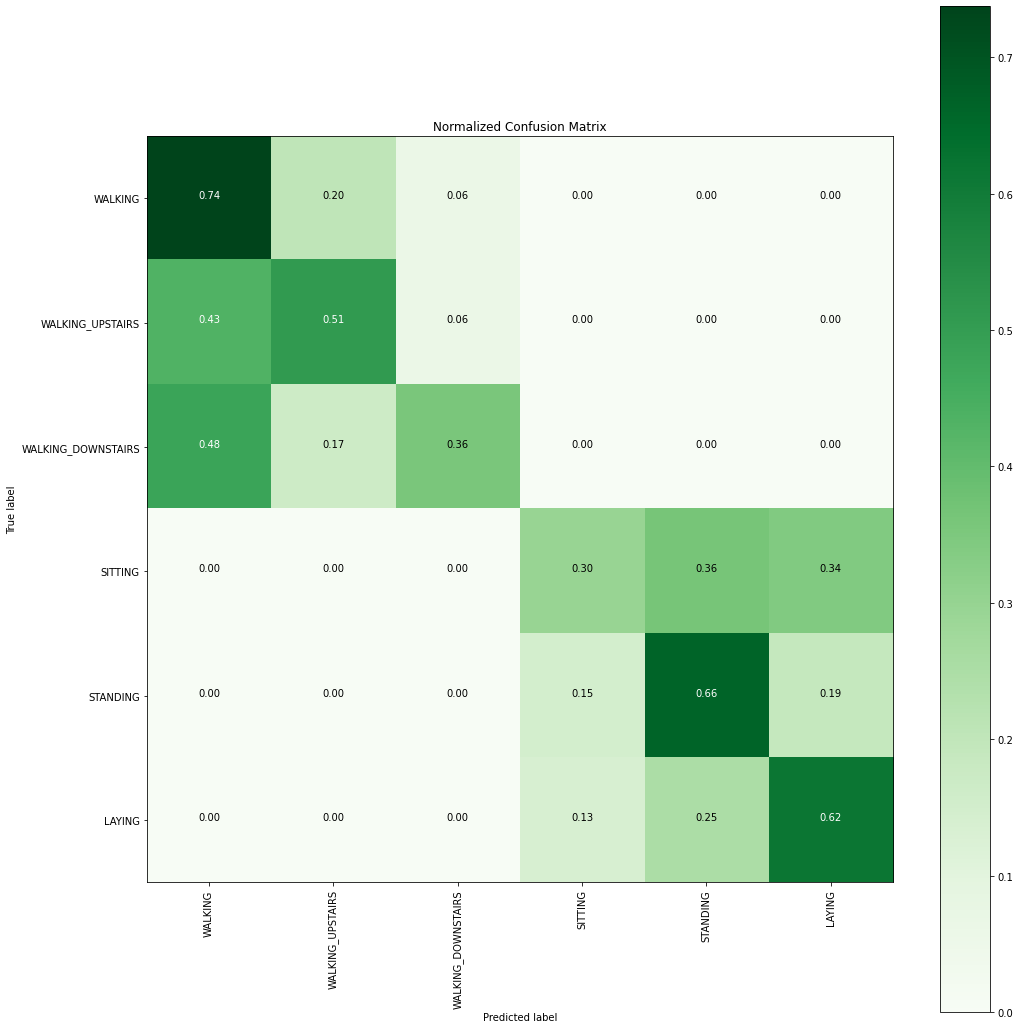


 F1 Score:0.5239938578977442


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5517315460433092
--------
n:  600
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:00.163469

Predicting test data
==> testing time:- 0:00:00.056690

==> Accuracy:- 0.5142763373810305


 ********Confusion Matrix********

 [[398 107  36   0   0   0]
 [242 220  30   0   0   0]
 [239  68 121   0   0   0]
 [  0   0   0 111 213 182]
 [  0   1   0  43 360 129]
 [  0   0   0  34 156 357]]


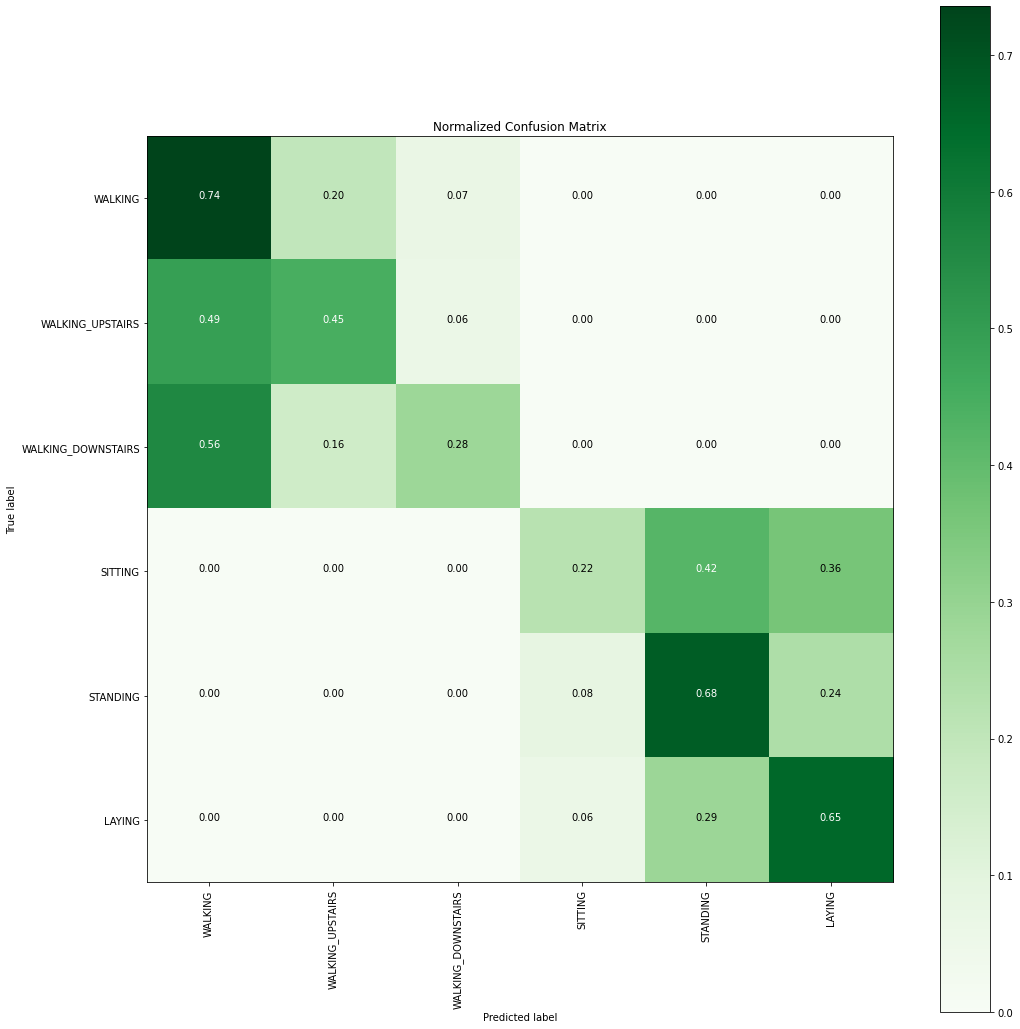


 F1 Score:0.4879361395577924


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=120)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 120}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5292626514457955
--------
n:  610
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:03:59.235269

Predicting test data
==> testing time:- 0:00:00.061920

==> Accuracy:- 0.4693140794223827


 ********Confusion Matrix********

 [[395 109  37   0   0   0]
 [281 175  36   0   0   0]
 [246  70 112   0   0   0]
 [  0   0   0  72 229 205]
 [  0   1   0  51 331 150]
 [  0   0   0  36 166 345]]


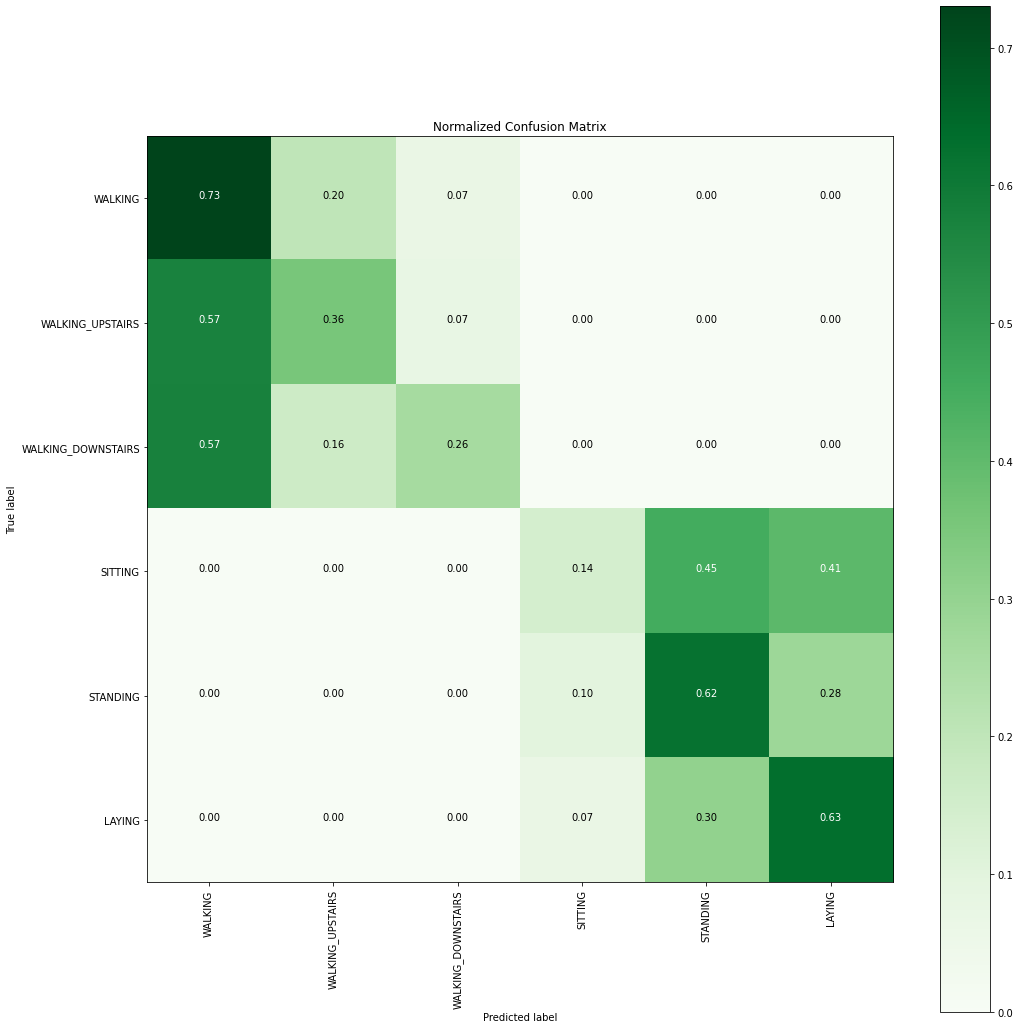


 F1 Score:0.43571815594381663


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.4877154719257989
--------
n:  620
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:11.653742

Predicting test data
==> testing time:- 0:00:00.077568

==> Accuracy:- 0.4453560879553659


 ********Confusion Matrix********

 [[435  81  25   0   0   0]
 [355 102  32   0   1   2]
 [286  52  89   0   1   0]
 [  0   1   0  35 261 209]
 [  3   2   0  38 332 158]
 [  0   0   0  21 162 364]]


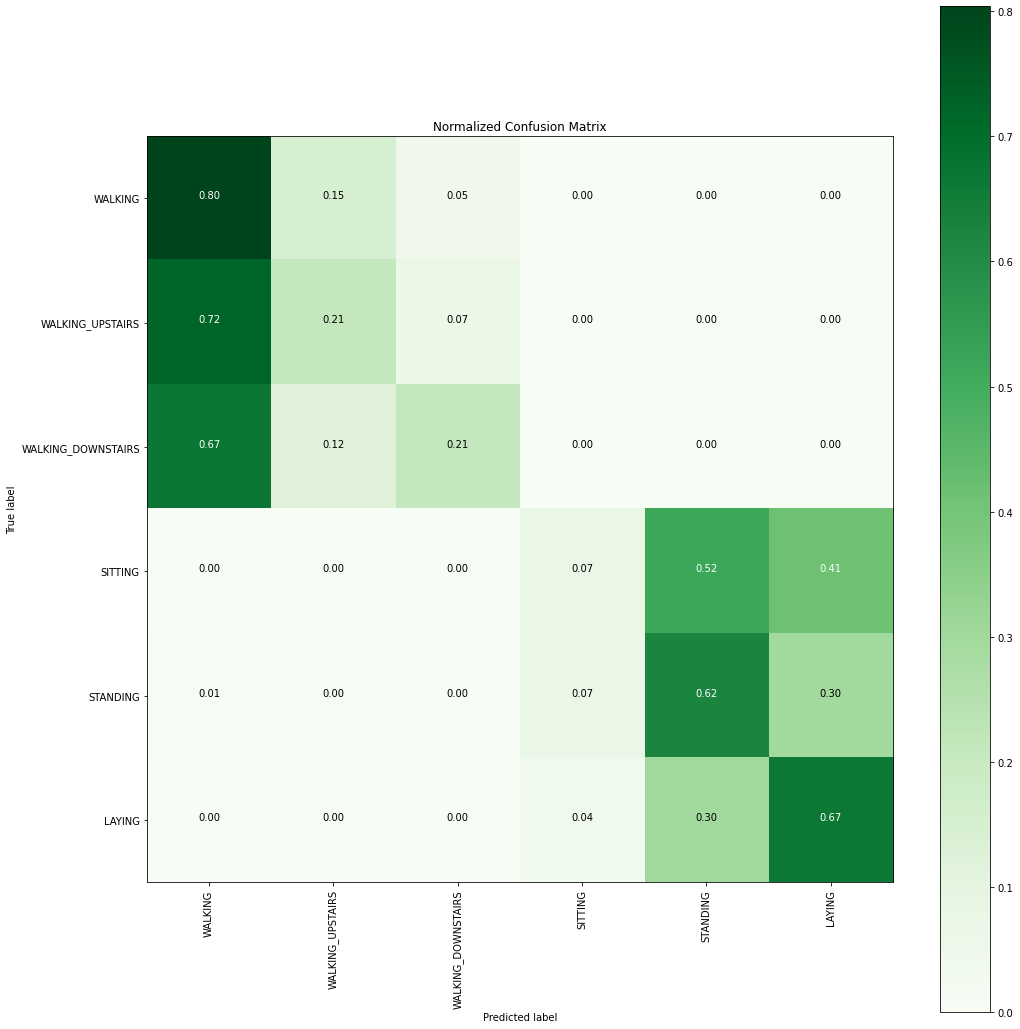


 F1 Score:0.3877898283809153


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.45506064361769505
--------
n:  630
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:16.289059

Predicting test data
==> testing time:- 0:00:00.060980

==> Accuracy:- 0.36823104693140796


 ********Confusion Matrix********

 [[422  72  32   1   8   6]
 [380  77  24   0   5   6]
 [333  64  18   1   5   7]
 [  7   2   0  34 240 223]
 [  6   3   0  36 297 191]
 [  4   0   0  37 232 274]]


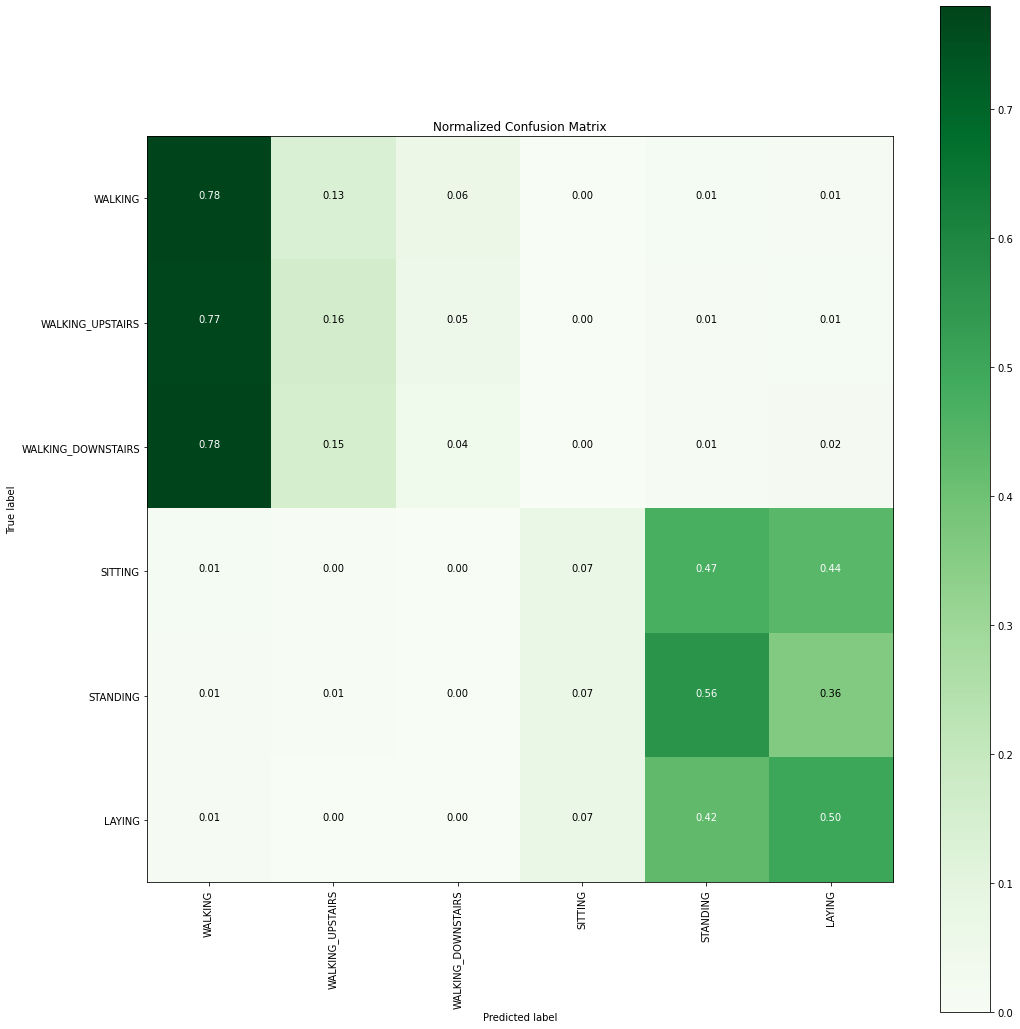


 F1 Score:0.2974514313021489


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.37843576425846576
--------
n:  640
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:26.431335

Predicting test data
==> testing time:- 0:00:00.065828

==> Accuracy:- 0.1690187069248441


 ********Confusion Matrix********

 [[181  10   0  25 186 139]
 [173  15   1  21 154 128]
 [149  14   1  10 144 110]
 [173  13   1  16 175 128]
 [187  18   6  17 172 133]
 [188  13   4  16 196 130]]


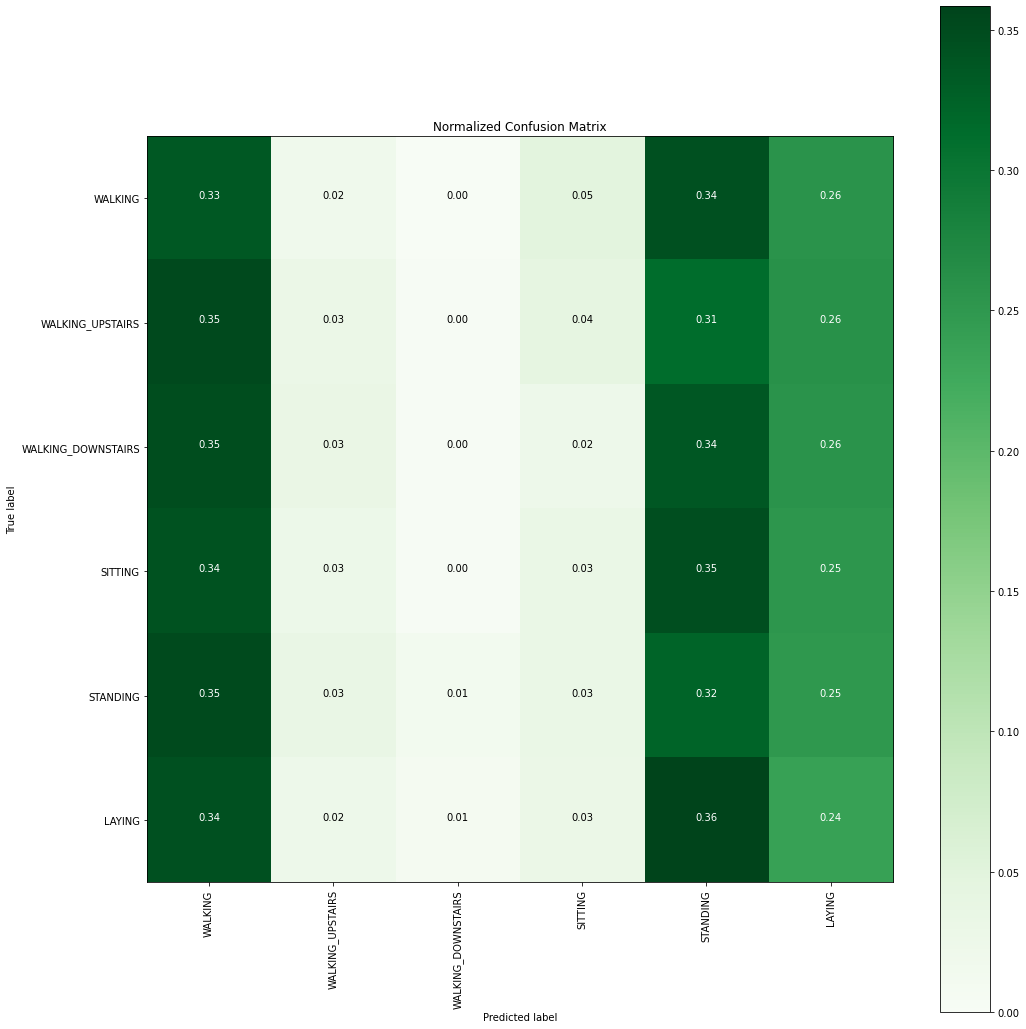


 F1 Score:0.12578343425946675


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=120)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 120}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.1813781583721103


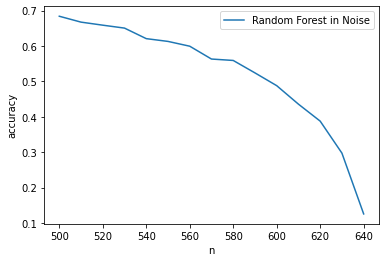

In [59]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
f1_array_random_har = list()


n_array = np.arange(500, 650, 10)

for n in n_array:

  print('--------')
  print('n:  '+ str(n))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col in features_uid[:n]:
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

    
  params = {'n_estimators': np.arange(110,151,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_array, f1_array_random_har, label='Random Forest in Noise')
ax.set_xlabel('n')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


In [60]:
# n_array 10刻み
print(f1_array_random_har)
print(f1_array_random_uid)

[0.6839378194759625, 0.6673173794135345, 0.6587030063552991, 0.6504622280475783, 0.6206955822381505, 0.6128664585106337, 0.599339728117687, 0.5630917509098434, 0.5591080669172513, 0.5239938578977442, 0.4879361395577924, 0.43571815594381663, 0.3877898283809153, 0.2974514313021489, 0.12578343425946675]
[0.217425284425719, 0.2014663815763245, 0.15204986392945552, 0.12692237380176244, 0.10931335778918723, 0.09519924868897059, 0.07304479718134356, 0.07318048955991265, 0.05792498688271246, 0.06534236886656267, 0.04845632702523501, 0.041738615974824804, 0.037974879334201427, 0.018887484441207268, 0.015476139177755543]


In [61]:
print(weighted_epsilon)

0.01


In [62]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [63]:
beep()

ModuleNotFoundError: No module named 'google.colab'